# Machine learning approach to FINEMET-type nanocrystalline materials design


### Our data set is collected from 45 literatures and the data contains following inputs:
#### Composition:
* Magnetic transition metal: Fe; 
* Early transition metal:  Nb	Ta	Hf	V	W	Ti	Mo	Zr	Cr; 
* Metalloid/Post-transition metal: Si	C	B	Al	Ga	P	Ge; 
* Late transition metal: Cu	Ag	Au	Zn;

#### Atomic properties for early transition metals:
* Mean atomic radius	
* Mean maximum valence electron	
* Mean atomic mass	
* Atomic occupancy

#### Atomic properties for early transition metals:
* Mean atomic radius	
* Mean maximum valence electron	
* Mean atomic mass	
* Atomic occupancy

#### Processing conditions
* Annealing temperature (K)	
* Annealing time (s)	 
* Longitudinal Annealing field (Dummy variable, 1 means exists and 0 means otherwise).	 
* Transverse Annealing field (Dummy variable, 1 means exists and 0 means otherwise).	
* Ribbon thickness (um) (Take average if a range is specified)

#### Materials property
* Grain Size (nm)	
* Core loss (kW/$m^3$) under field 0.2T, 100kHz	
* Magnetic saturation(T)	
* Coercivity (A/m)	
* Magnetostriction ($10^{-6}$)	
* Electrical resistivity ($\mu \Omega$*m)	
* Permeability 1kHz	
* Curie Temperature (K)

In [84]:
import pandas as pd
from scipy import stats
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn.linear_model import lasso_path
import rpy2.robjects as robjects
from rpy2.robjects import FloatVector
from rpy2.robjects.packages import importr
import warnings
warnings.filterwarnings('ignore')
statsr = importr('stats')
base = importr('base')
moddict={}

#### Initial data filter
Read the data set and sort the data into separate dataframes with each materials' property(excluding grain size) as a response variable. Delete the rows which response variables are NaN. Each feature must have at least two distinctive values

In [85]:
data=pd.read_excel('data_base.xlsx')
data=data.drop(columns=['Nb','Ta','Hf','V','W','Ti','Mo','Zr'])
dataheader=list(data.columns.values)
a=data[dataheader[-1]].nunique(dropna=True)
nfeature=22
predictors=data[dataheader[0:nfeature]]
nprps=len(dataheader)-nfeature
modeldatas={}
for i in range(nprps):
    prp=data[dataheader[i+nfeature]]
    datas=predictors.copy()
    datas[dataheader[i+nfeature]]=prp
    datas = datas[pd.notnull(datas[dataheader[i+nfeature]])]
    header2=list(datas.columns.values)
    for j in range(nfeature+1):
        a=datas[header2[j]].nunique(dropna=True)
        if a<2:
            if header2[j]!='Longitudinal_Annealing_field' and header2[j]!='Transverse_Annealing_field':
                datas=datas.drop(columns=[header2[j]])
    modeldatas[dataheader[i+nfeature]]=datas

#### Function that round numbers to precision

In [86]:
def round_to(n, precision):
    correction = 0.5 if n >= 0 else -0.5
    return int( n/precision+correction ) * precision

#### Function that do model selection with lasso and bic

In [87]:
def lasso_bic(dataset,Y,X):
    params = {'legend.fontsize': 'medium',
          'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
    pylab.rcParams.update(params)
    header=list(dataset.columns.values)
    laso = linear_model.LassoLarsIC(criterion='bic',fit_intercept=True)
    laso.fit(X, Y)
    coefsl=laso.coef_  
    featureindex=list(np.nonzero(coefsl)[0])
    header=np.array(header)
    dataselect=dataset[header[featureindex]].copy()
    dataselect[header[-1]]=dataset[header[-1]].copy()
    return dataselect

#### Function that do box cox transformation

In [88]:
def box_cox(dataset,indexes):
    coedm=dataset.copy().as_matrix()
    header=list(dataset.columns.values)
    lams={}
    for i in range(np.size(coedm,1)-1):
        if i not in indexes:
            tmp=coedm[:,i]
            tmp[tmp==0]=0.00001
            xt,lam=stats.boxcox(tmp)
            lam=round_to(lam,0.5)
            if lam <3.5 and lam > -1.5:
                lams[header[i]]=lam         
                if lam==0:
                    coedm[:,i]=np.log(coedm[:,i])
                else:
                    coedm[:,i]=np.power(coedm[:,i],lam)
            else:
                lams[header[i]]=1
        else:
            lams[header[i]]=1
    datatrans=pd.DataFrame(coedm,columns=header)
    return datatrans,lams

### Analyse the Coercivity
##### Plot the distribution of coercivity

Count data entry:
487


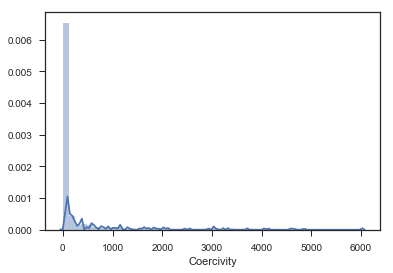

In [90]:
coercivitydata=modeldatas['Coercivity'].reset_index(drop=True)
n=coercivitydata.shape[0]
coercivitydata=coercivitydata.dropna(axis=1,thresh=int(0.4*n))
coercivitydata=coercivitydata.fillna(coercivitydata.mean())
header=list(coercivitydata.columns.values)
indexes=[]
indexes.append(header.index('Longitudinal_Annealing_field'))
indexes.append(header.index('Transverse_Annealing_field'))
designmatrix=coercivitydata.as_matrix()
%matplotlib inline
sns.distplot(coercivitydata['Coercivity'])
print('Count data entry:')
print(n)

##### Using natural log transformation to reshape the response variable.

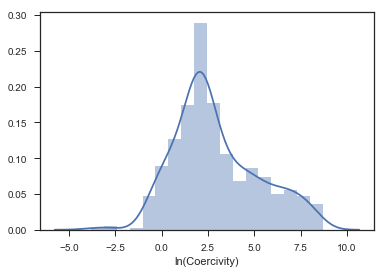

In [91]:
coercivitydata['ln(Coercivity)']=pd.Series(np.log(coercivitydata['Coercivity']),index=coercivitydata.index)
sns.distplot(coercivitydata['ln(Coercivity)'])

##### Show data count on range specified

In [136]:
# Split the dataframe using the range specified
ranges = [-5,-2.5,0,1,2,3,4,5,6,7,8,9]
groupb=coercivitydata.groupby(pd.cut(coercivitydata['ln(Coercivity)'], ranges))
coerdg=[groupb.get_group(x) for x in groupb.groups]
groupd=groupb.count()
groupd=groupd['ln(Coercivity)']
print(groupd) # show data count under different ranges

ln(Coercivity)
(-5.0, -2.5]      3
(-2.5, 0.0]      33
(0.0, 1.0]       54
(1.0, 2.0]      103
(2.0, 3.0]      107
(3.0, 4.0]       47
(4.0, 5.0]       43
(5.0, 6.0]       36
(6.0, 7.0]       25
(7.0, 8.0]       24
(8.0, 9.0]       12
Name: ln(Coercivity), dtype: int64


##### Random sample the range (1.0, 2.0] and (2.0,3.0] to reduce the number of instances and resemble a normal distribution

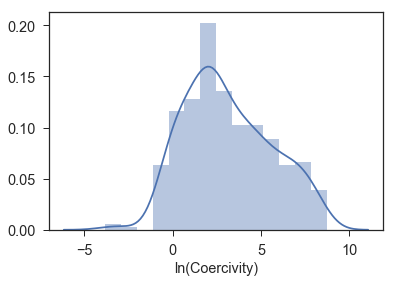

In [137]:
train12=coerdg[3].sample(frac=0.6,random_state=200)
test12=coerdg[3].drop(train12.index)
train23=coerdg[4].sample(frac=0.6,random_state=200)
test23=coerdg[4].drop(train23.index)
coerdatatest=pd.concat([test12,test23])
coerdg[3]=train12
coerdg[4]=train23
coerdatanew=pd.concat(coerdg[0:len(coerdg)])
sns.distplot(coerdatanew['ln(Coercivity)'])

##### Doing box cox transformation of features to get closer to normal distribution.

In [138]:
# drop colums that have less than 4 distinct values
header=list(coerdatanew.columns.values)
for j in range(len(header)):
    a=coerdatanew[header[j]].nunique(dropna=True)
    if a<4:
        if header[j]!='Longitudinal_Annealing_field' and header[j]!='Transverse_Annealing_field':
            coerdatanew=coerdatanew.drop(columns=[header[j]])
# boxcox transformation
coedm=coerdatanew.as_matrix()
header=list(coerdatanew.columns.values)
indexes=[]
indexes.append(header.index('Longitudinal_Annealing_field'))
indexes.append(header.index('Transverse_Annealing_field'))
lams={}
for i in range(np.size(coedm,1)-2):
    if i not in indexes:
        tmp=coedm[:,i]
        tmp[tmp==0]=0.00001
        xt,lam=stats.boxcox(tmp)
        lam=round_to(lam,0.5)
        if lam <3.5 and lam > -1.5:
            lams[header[i]]=lam         
            if lam==0:
                coedm[:,i]=np.log(coedm[:,i])
            else:
                coedm[:,i]=np.power(coedm[:,i],lam)
        else:
            lams[header[i]]=1
    else:
         lams[header[i]]=1
coerdatatrans=pd.DataFrame(coedm,columns=header)
lamsframe=pd.DataFrame.from_dict(lams,orient='index')
writer = pd.ExcelWriter('boxcox_coercivity.xlsx')
lamsframe.to_excel(writer,'Coercivity')
writer.save()

##### Model selection by Lasso based on BIC

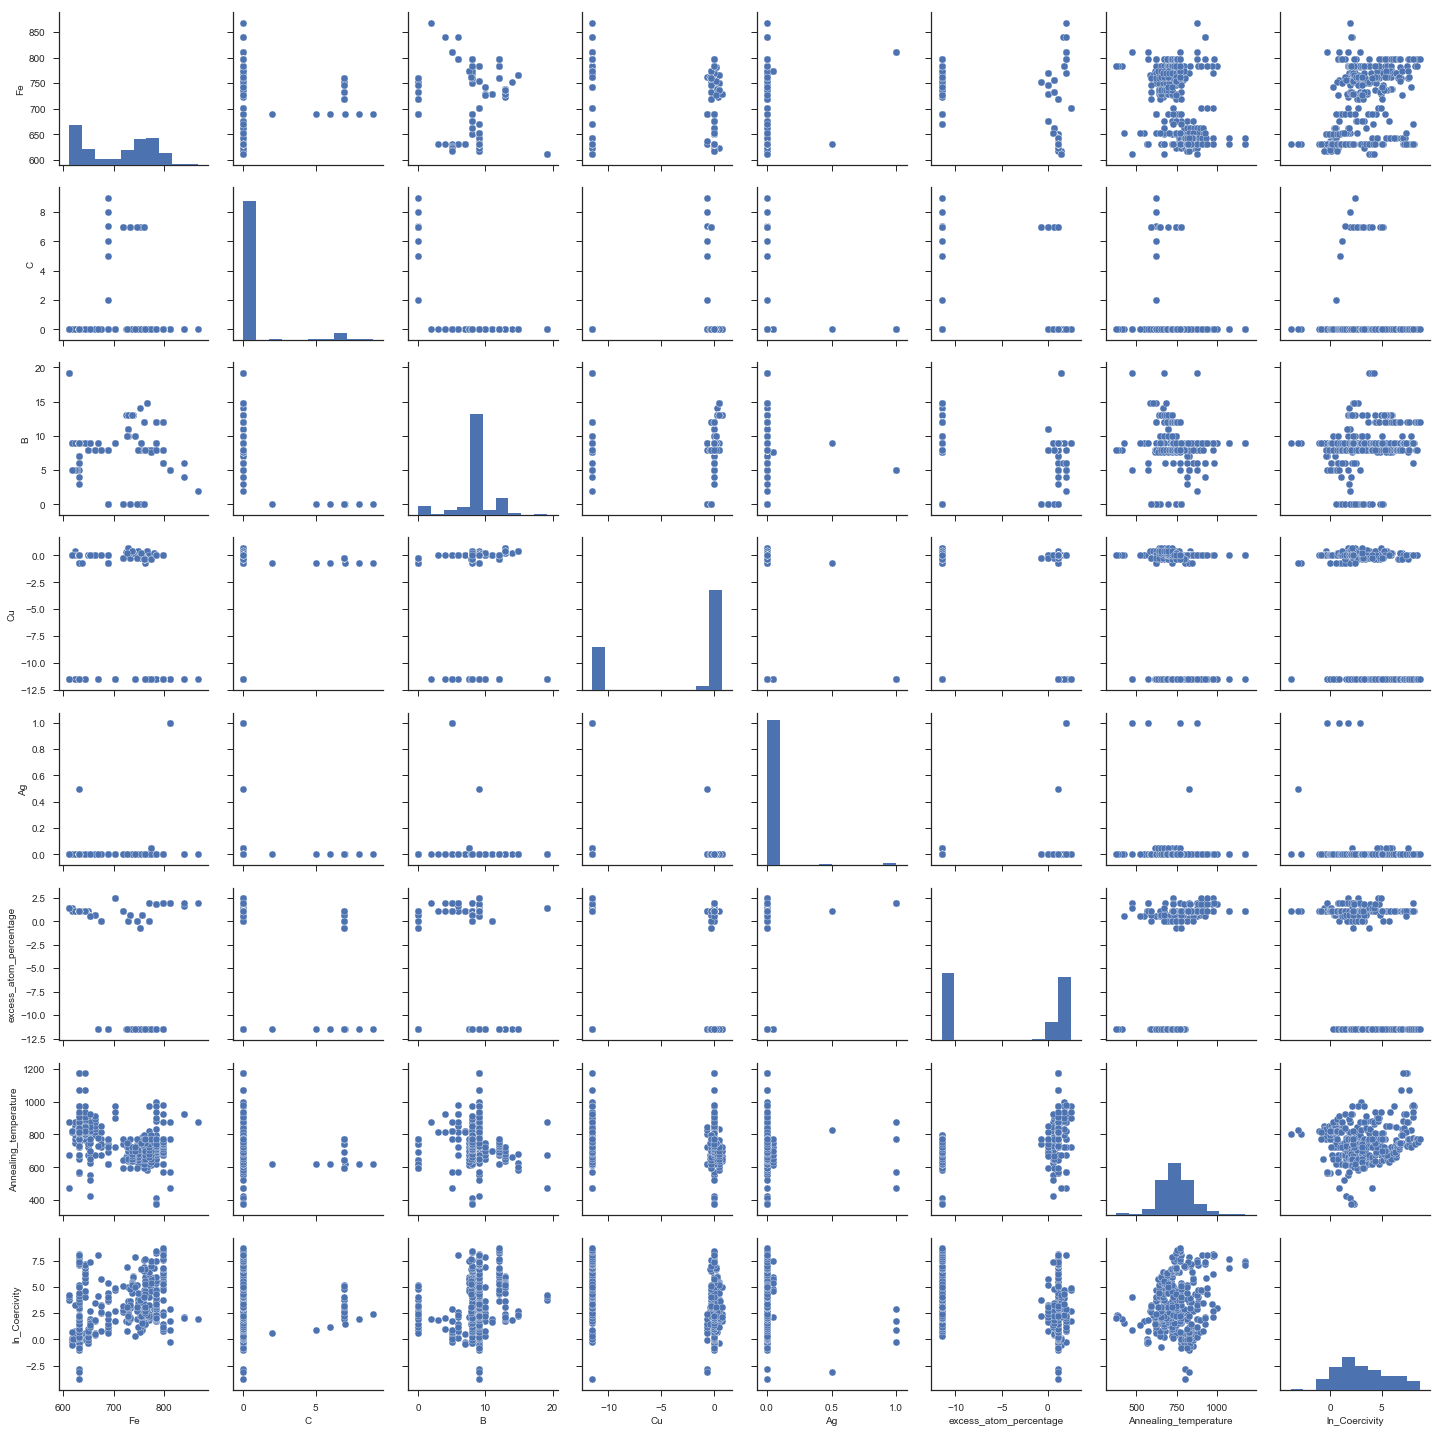

In [139]:
params = {'legend.fontsize': 'medium',
          'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)
Y=coerdatatrans['ln(Coercivity)'].as_matrix()
X=coerdatatrans.drop(columns=['ln(Coercivity)','Coercivity'])
header=list(coerdatatrans.columns.values)
laso = linear_model.LassoLarsIC(criterion='bic',fit_intercept=True)
laso.fit(X, Y)
coefsl=laso.coef_  
featureindex=list(np.nonzero(coefsl)[0])
header=np.array(header)
coerdatatransselect=coerdatatrans[header[featureindex]].copy().reset_index(drop=True)
coerdatatransselect['ln_Coercivity']=coerdatatrans['ln(Coercivity)'].copy()
coerdatatransselect=coerdatatransselect.drop(columns=['Longitudinal_Annealing_field','Transverse_Annealing_field'])
sns.pairplot(coerdatatransselect)

##### Building ordinary least squares model using transformed variables

In [140]:
# building model function
header=list(coerdatatransselect.columns.values)
lmstr=header[-1]+" ~ "+header[0]
for i in range(len(header)-2):
    lmstr=lmstr+'+'+header[i+1]
# ordinary least squares model
mod = ols(lmstr,data=coerdatatransselect).fit()

##### Partial regression plot

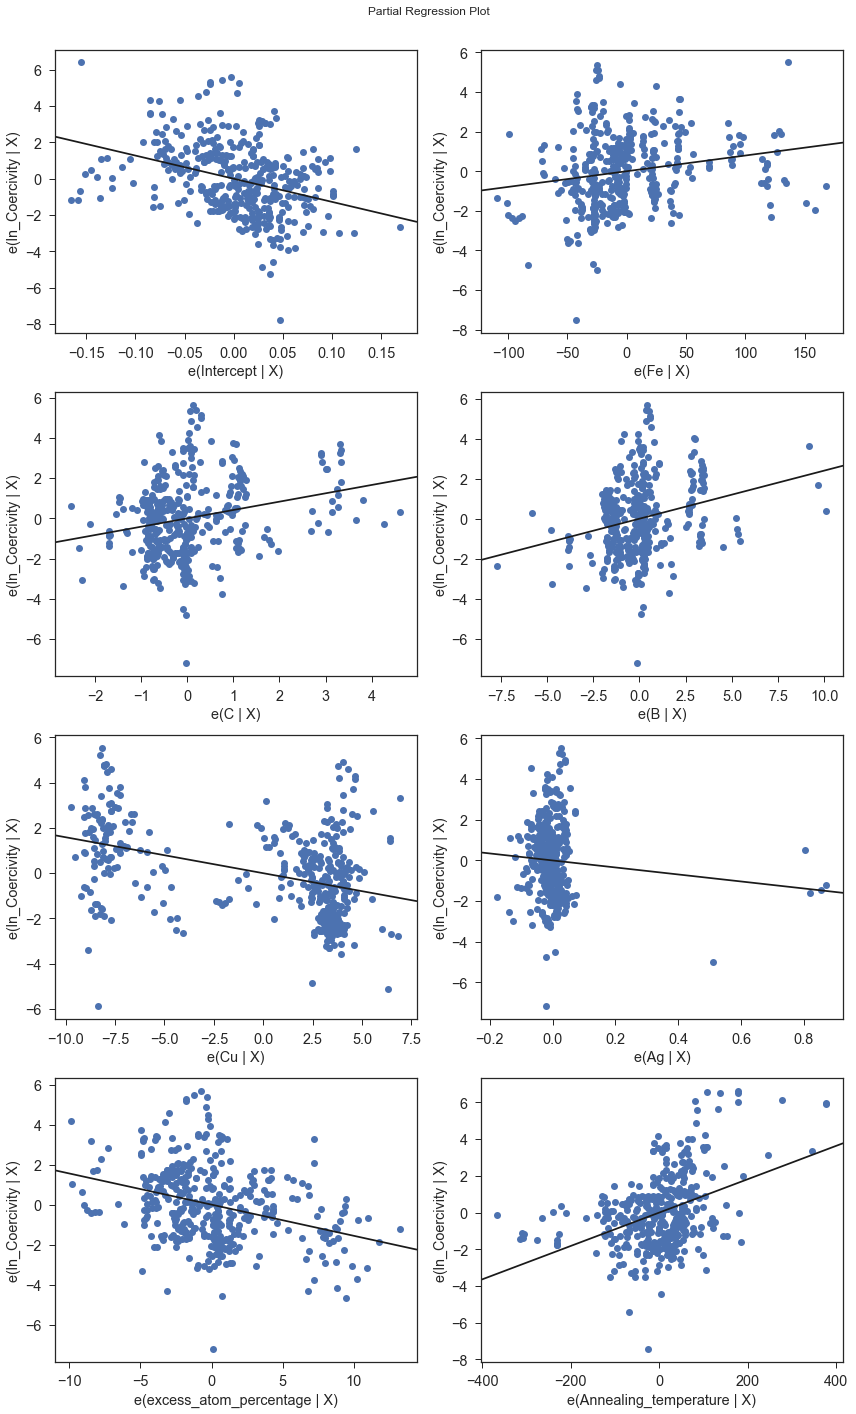

In [141]:
params = {'legend.fontsize': 'x-large',
          'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
fig = plt.figure(figsize=(12,20))
fig = sm.graphics.plot_partregress_grid(mod,fig=fig)

#### Influential plot using cooks distance

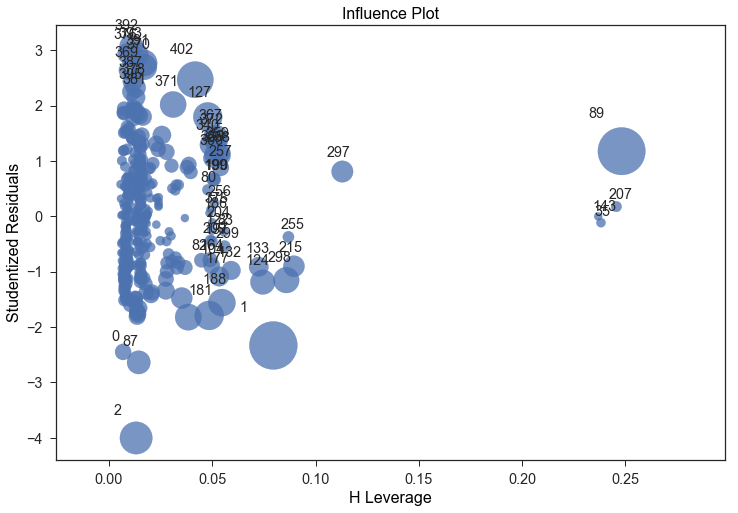

In [142]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(mod, ax=ax, criterion="Cooks") 

##### Get rid of high leverage point and remodel

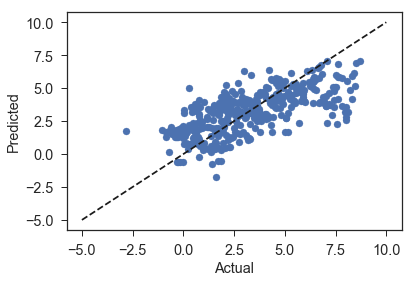

In [143]:
coerdatatransselect2=coerdatatransselect.drop(coerdatatransselect.index[[89,2,1,297,207,143,35]])
mod = ols(lmstr,data=coerdatatransselect2).fit()
Y=coerdatatransselect2['ln_Coercivity'].as_matrix()
fig,ax = plt.subplots()
ax.scatter(Y,mod.fittedvalues)
ax.plot([-5,10],[-5,10],'k--')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

#### Print coeficients of regression expression

In [144]:
print(mod.params)
moddict['Coercivity']=[mod,lams,'ln(y)']

Intercept                -12.456247
Fe                         0.007155
C                          0.415063
B                          0.238178
Cu                        -0.159006
Ag                         2.956130
excess_atom_percentage    -0.161373
Annealing_temperature      0.009449
dtype: float64


### Analyzing magnetostriction
##### Plot the distribution of magnetostriction

Count data entry:
112


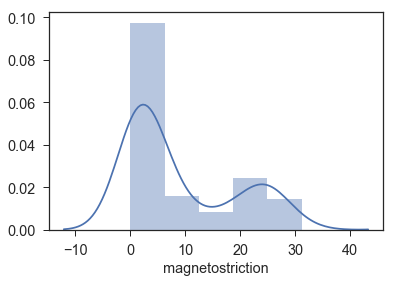

In [152]:
magnetostricdata=modeldatas['magnetostriction'].reset_index(drop=True)
n=magnetostricdata.shape[0]
magnetostricdata=magnetostricdata.dropna(axis=1,thresh=int(0.4*n))
magnetostricdata=magnetostricdata.fillna(magnetostricdata.mean())
# only analyze positive values of magnetostriction
magnetostricdata=magnetostricdata[magnetostricdata['magnetostriction']>=0].reset_index(drop=True)
magnetostricdata=magnetostricdata.drop(columns=['Longitudinal_Annealing_field','Transverse_Annealing_field'])
header=list(magnetostricdata.columns.values)
for j in range(len(header)):
    a=magnetostricdata[header[j]].nunique(dropna=True)
    if a<5:
        if header[j]!='Longitudinal_Annealing_field' and header[j]!='Transverse_Annealing_field':
            magnetostricdata=magnetostricdata.drop(columns=[header[j]])
designmatrix=magnetostricdata.as_matrix()
header=list(magnetostricdata.columns.values)
sns.distplot(magnetostricdata['magnetostriction'])
n=magnetostricdata.shape[0]
print('Count data entry:')
print(n)

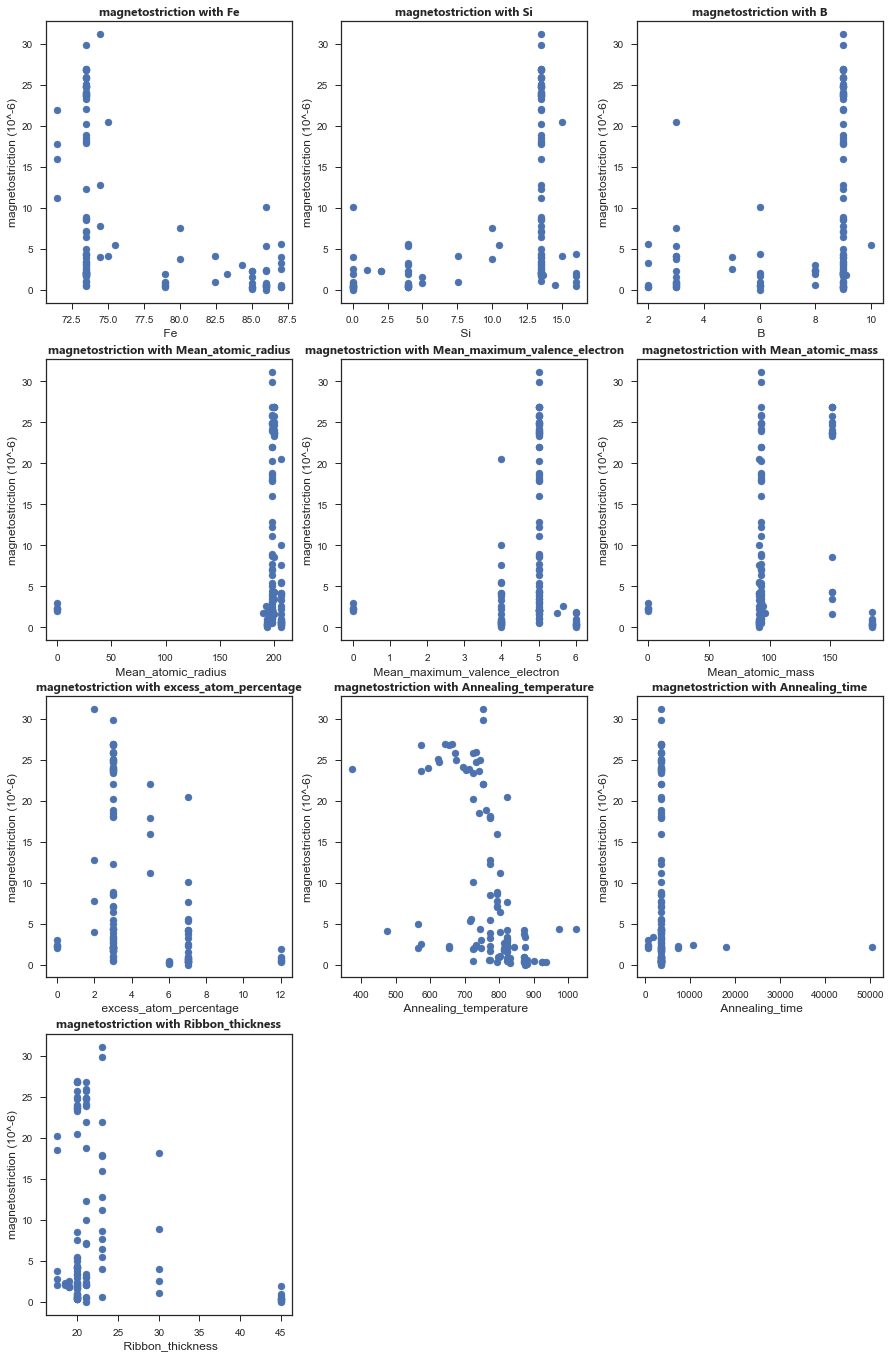

In [153]:
params = {'legend.fontsize': 'medium',
          'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)
fig = plt.figure(figsize=(15,30))
for i in range(np.size(designmatrix,1)-1):
    ax = fig.add_subplot(5,3,i+1)
    ax.scatter(designmatrix[:,i],designmatrix[:,-1],marker="o", s=50)
    ax.set_xlabel(" %s"%header[i],fontsize=12, fontweight='normal')
    ax.set_ylabel("magnetostriction (10^-6)",fontsize=12, fontweight='normal')
    ax.set_title("magnetostriction with %s"%header[i], fontweight='bold', fontsize=12, fontname='Segoe UI')
    #plt.savefig("Figure2_{y}.png".format(y=header[i]),dpi=500)


In [159]:
# Transform Y with power of 1/3
Y1=np.power(designmatrix[:,-1],1/3)
magnetostricdata['trans_magnetostriction']=pd.Series(Y1, index=magnetostricdata.index)
Y=magnetostricdata['trans_magnetostriction'].as_matrix()
X=magnetostricdata.drop(columns=['magnetostriction','trans_magnetostriction']).as_matrix()
header=list(magnetostricdata.columns.values)
# Model selection with Lasso and BIC
laso = linear_model.LassoLarsIC(criterion='bic',fit_intercept=True)
laso.fit(X, Y)
coefsl=laso.coef_  
featureindex=list(np.nonzero(coefsl)[0])
header=np.array(header)
magnetostricdataselect=magnetostricdata[header[featureindex]].copy().reset_index(drop=True)
magnetostricdataselect['trans_magnetostriction']=magnetostricdata['trans_magnetostriction'].copy()

#### Model build ordinary least squares

In [160]:
header=list(magnetostricdataselect.columns.values)
lmstr=header[-1]+" ~ "+header[0]
for i in range(len(header)-2):
    lmstr=lmstr+'+'+header[i+1]
mod = ols(lmstr,data=magnetostricdataselect).fit()

#### Partial regression plot

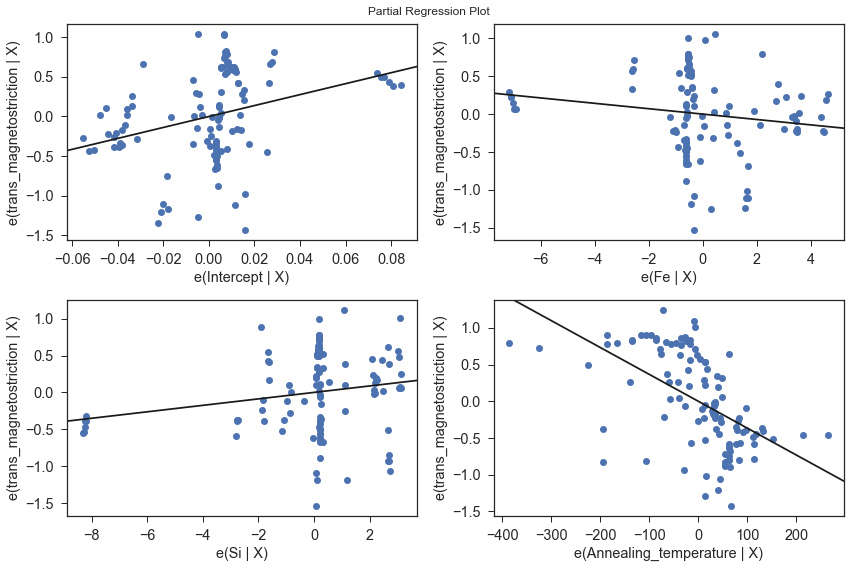

In [165]:
params = {'legend.fontsize': 'x-large',
          'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(mod, fig=fig)

#### Influential plot using cooks distance

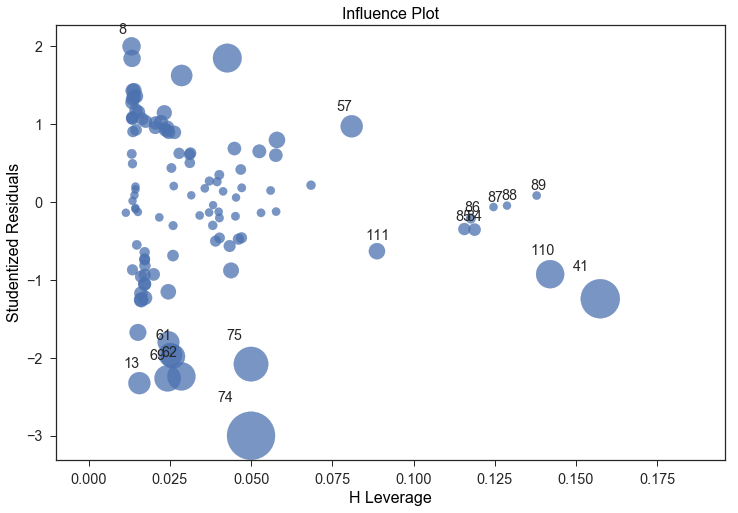

In [166]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(mod, ax=ax, criterion="Cooks") 

#### Get rid of high leverage point and remodel

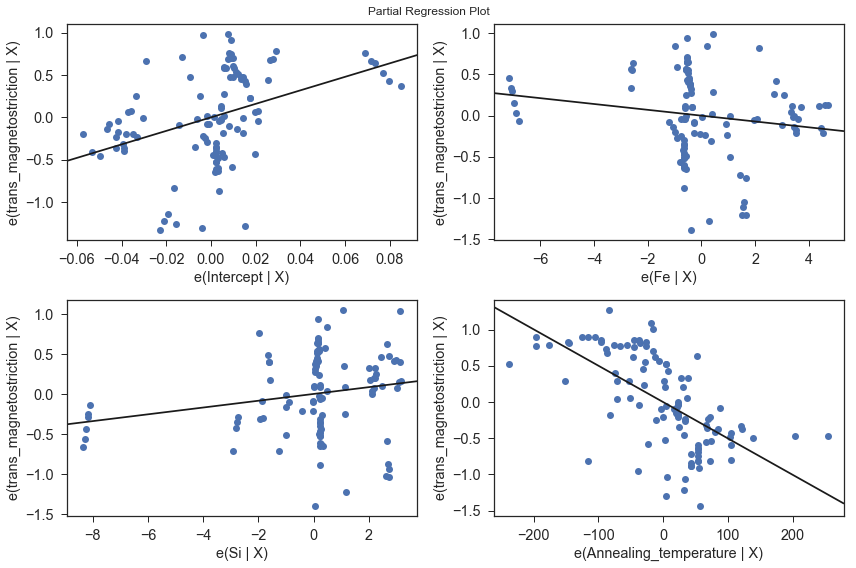

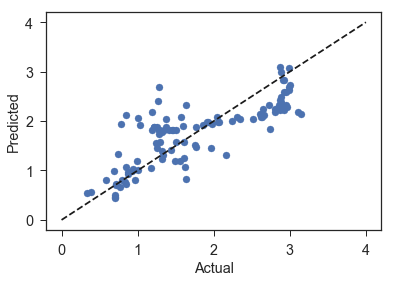

In [167]:
magnetostricdataselect=magnetostricdataselect.drop(magnetostricdataselect.index[[74,75,41,110]])
mod = ols(lmstr,data=magnetostricdataselect).fit()
Y=magnetostricdataselect['trans_magnetostriction'].as_matrix()
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(mod,fig=fig)
fig,ax = plt.subplots()
ax.scatter(Y,mod.fittedvalues)
ax.plot([0,4],[0,4],'k--')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

#### Print coeficients of regression expression of transformed magnetostriction

In [168]:
print(mod.params)
moddict['magnetostriction']=[mod,'none','y^1/3']

Intercept                7.989950
Fe                      -0.035358
Si                       0.042426
Annealing_temperature   -0.005026
dtype: float64


### Analyzing Magnetic saturation
#### Plot distribution of magnetic saturation

Number of data entry
270


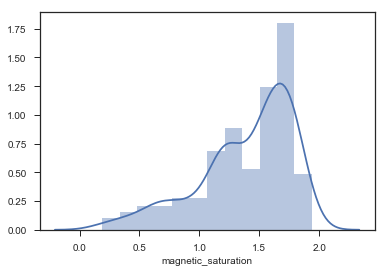

In [327]:
magneticsatdata=modeldatas['magnetic_saturation'].reset_index(drop=True)
n=magneticsatdata.shape[0]
magneticsatdata=magneticsatdata.dropna(axis=1,thresh=int(0.4*n))
magneticsatdata=magneticsatdata.fillna(magneticsatdata.mean())
header=list(magneticsatdata.columns.values)
indexes=[]
indexes.append(header.index('Longitudinal_Annealing_field'))
indexes.append(header.index('Transverse_Annealing_field'))
header=list(magneticsatdata.columns.values)
for j in range(len(header)):
    a=magneticsatdata[header[j]].nunique(dropna=True)
    if a<5:
        if header[j]!='Longitudinal_Annealing_field' and header[j]!='Transverse_Annealing_field':
            magneticsatdata=magneticsatdata.drop(columns=[header[j]])
designmatrix=magneticsatdata.as_matrix()
header=list(magneticsatdata.columns.values)
sns.distplot(magneticsatdata['magnetic_saturation'])
print("Number of data entry")
print(n)

#### Plot magnetic saturation with all the predictors

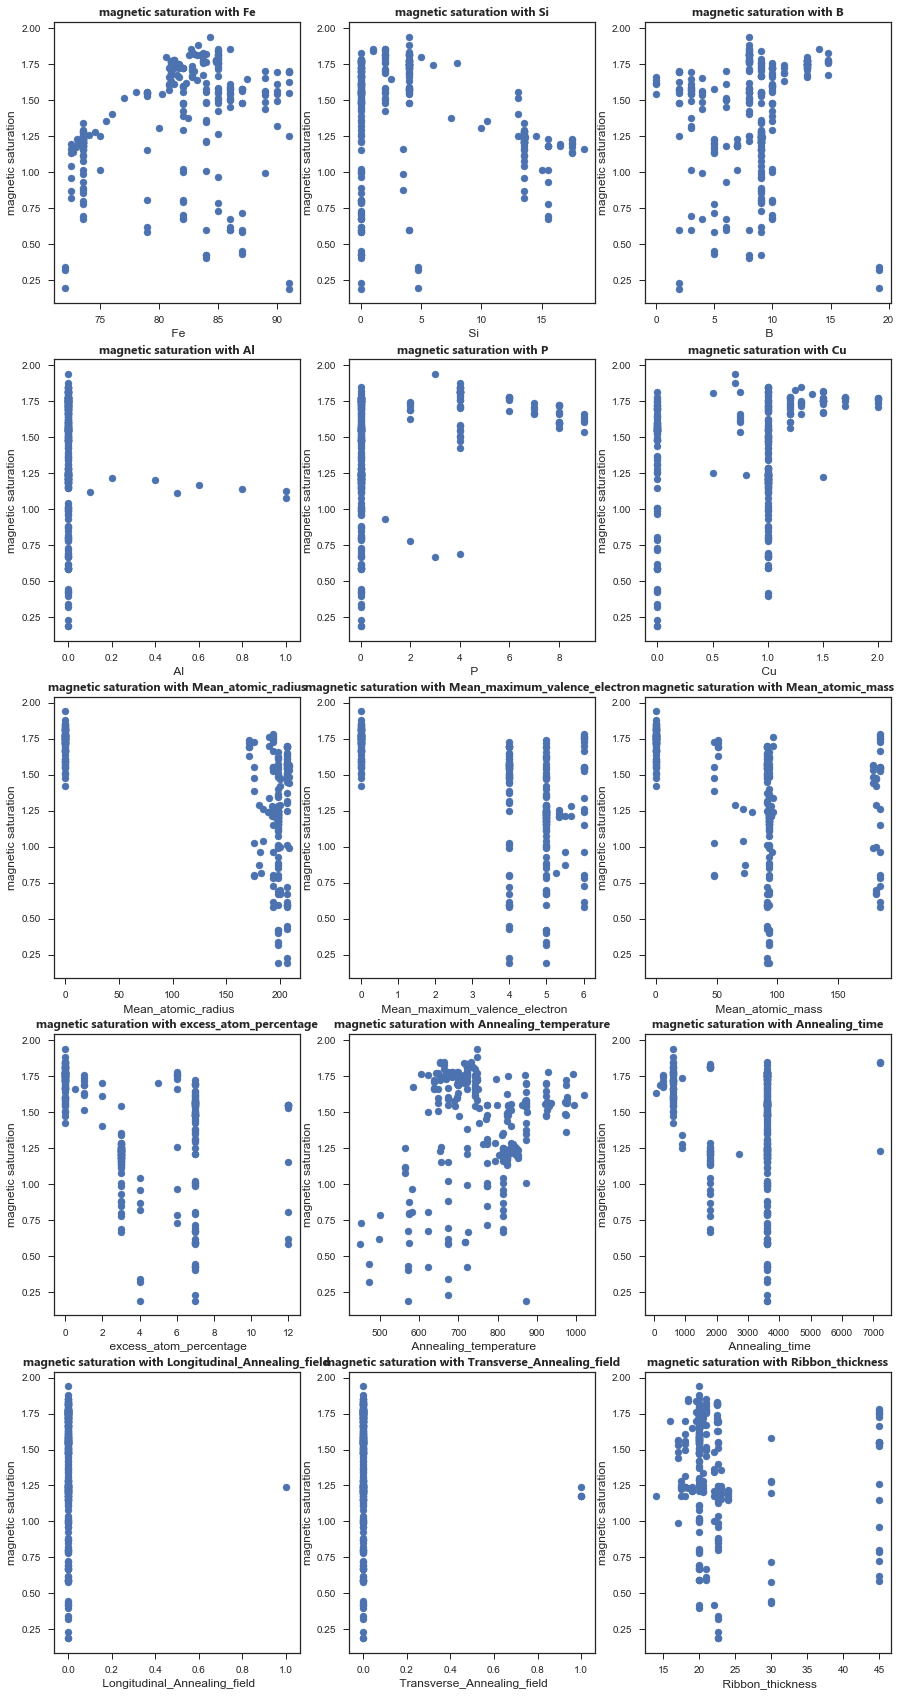

In [328]:
params = {'legend.fontsize': 'medium',
          'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)
fig = plt.figure(figsize=(15,30))
for i in range(np.size(designmatrix,1)-1):
    ax = fig.add_subplot(5,3,i+1)
    ax.scatter(designmatrix[:,i],designmatrix[:,-1],marker="o", s=50)
    ax.set_xlabel(" %s"%header[i],fontsize=12, fontweight='normal')
    ax.set_ylabel("magnetic saturation",fontsize=12, fontweight='normal')
    ax.set_title("magnetic saturation with %s"%header[i], fontweight='bold', fontsize=12, fontname='Segoe UI')
    #plt.savefig("Figure2_{y}.png".format(y=header[i]),dpi=500)

#### Split the data set based on whether it has early transition metal and analyze them separately

In [329]:
ranges = [-0.1,0.2,10]
groupb=magneticsatdata.groupby(pd.cut(magneticsatdata['excess_atom_percentage'], ranges))
magsatdg=[groupb.get_group(x) for x in groupb.groups]
groupd=groupb.count()
groupd=groupd['excess_atom_percentage']
print(groupd) # show data count under different ranges

excess_atom_percentage
(-0.1, 0.2]     86
(0.2, 10.0]    174
Name: excess_atom_percentage, dtype: int64


### Analyzing magnetic saturation with early transition metal

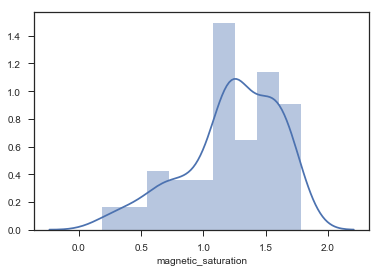

In [330]:
magsatex=magsatdg[1]
sns.distplot(magsatex['magnetic_saturation'])

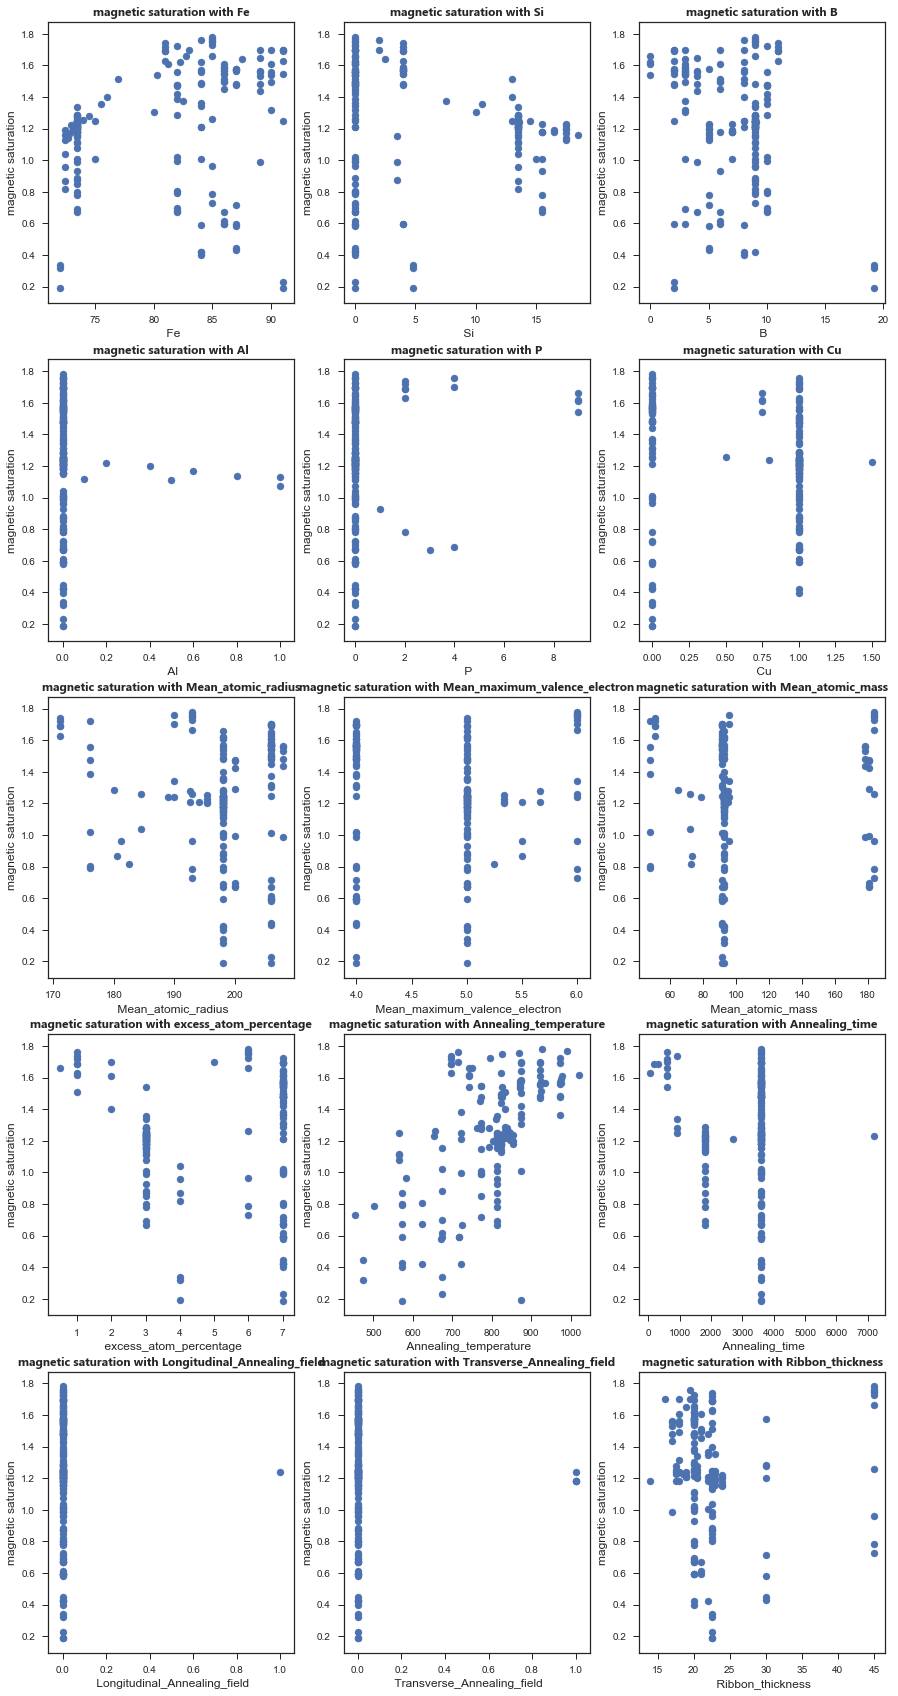

In [331]:
designmatrix=magsatex.as_matrix()
params = {'legend.fontsize': 'medium',
          'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)
fig = plt.figure(figsize=(15,30))
for i in range(np.size(designmatrix,1)-1):
    ax = fig.add_subplot(5,3,i+1)
    ax.scatter(designmatrix[:,i],designmatrix[:,-1],marker="o", s=50)
    ax.set_xlabel(" %s"%header[i],fontsize=12, fontweight='normal')
    ax.set_ylabel("magnetic saturation",fontsize=12, fontweight='normal')
    ax.set_title("magnetic saturation with %s"%header[i], fontweight='bold', fontsize=12, fontname='Segoe UI')

#### Box cox transformation

In [332]:
designmatrix=magsatex.as_matrix()
header=list(magsatex.columns.values)
lams={}
for i in range(np.size(designmatrix,1)-1):
    if i not in indexes:
        tmp=designmatrix[:,i]
        tmp[tmp==0]=0.00001
        xt,lam=stats.boxcox(tmp)
        lam=round_to(lam,0.5)
        if lam <3.5 and lam > -1.5:
            lams[header[i]]=lam         
            if lam==0:
                designmatrix[:,i]=np.log(designmatrix[:,i])
            else:
                designmatrix[:,i]=np.power(designmatrix[:,i],lam)
        else:
            lams[header[i]]=1
    else:
         lams[header[i]]=1
magsatextrans=pd.DataFrame(designmatrix,columns=header)
lamsframe=pd.DataFrame.from_dict(lams,orient='index')
writer = pd.ExcelWriter('boxcox_magsat.xlsx')
lamsframe.to_excel(writer,'magnetic saturation')
writer.save()

#### Lasso with BIC for model selection, pair plot for variables after selection

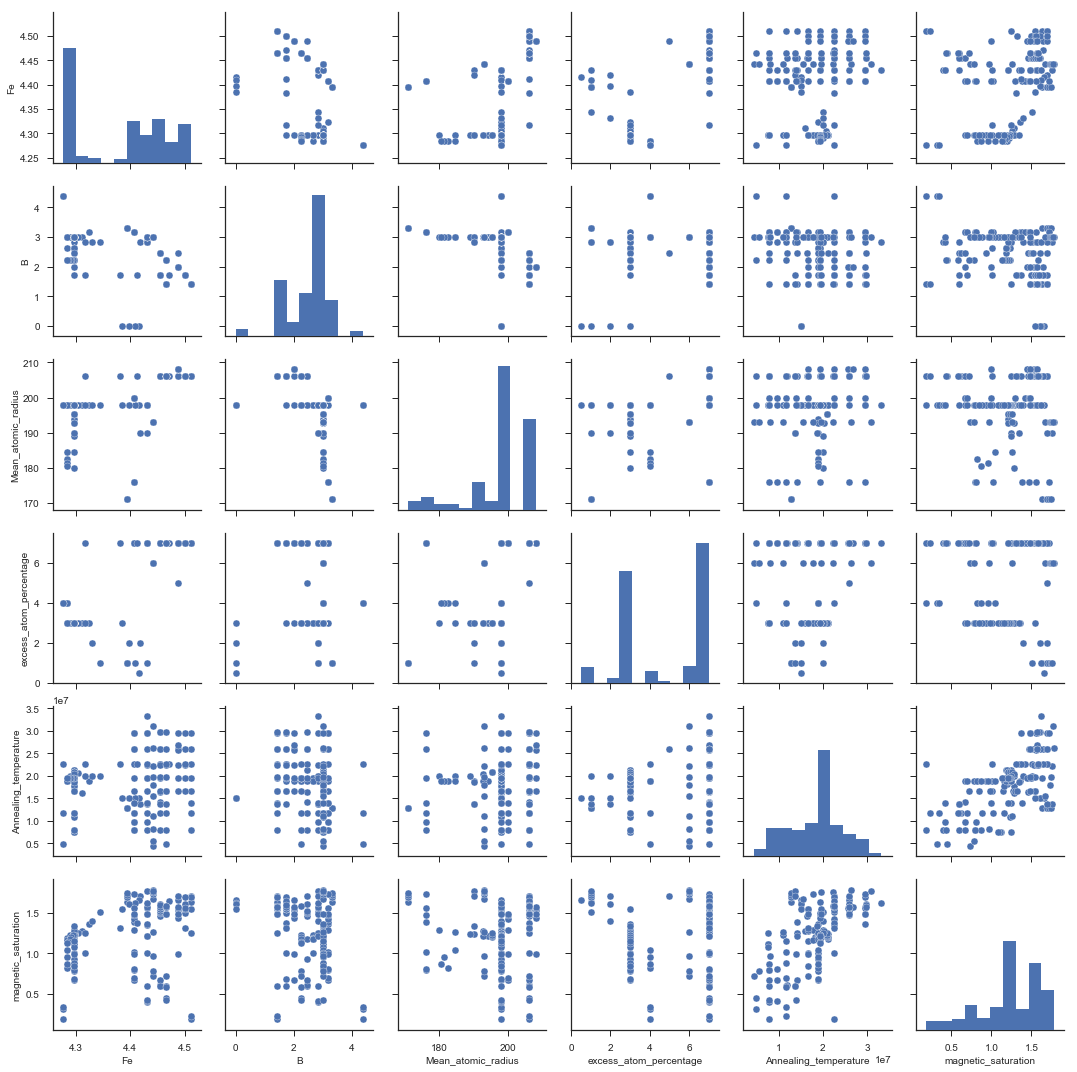

In [333]:
dataset=magsatextrans
Y=magsatextrans['magnetic_saturation'].as_matrix()
X=magsatextrans.drop(columns=['magnetic_saturation']).as_matrix()
magsatextransselect=lasso_bic(dataset,Y,X).reset_index(drop=True)
sns.pairplot(magsatextransselect)

#### Model build and partial regressional plot

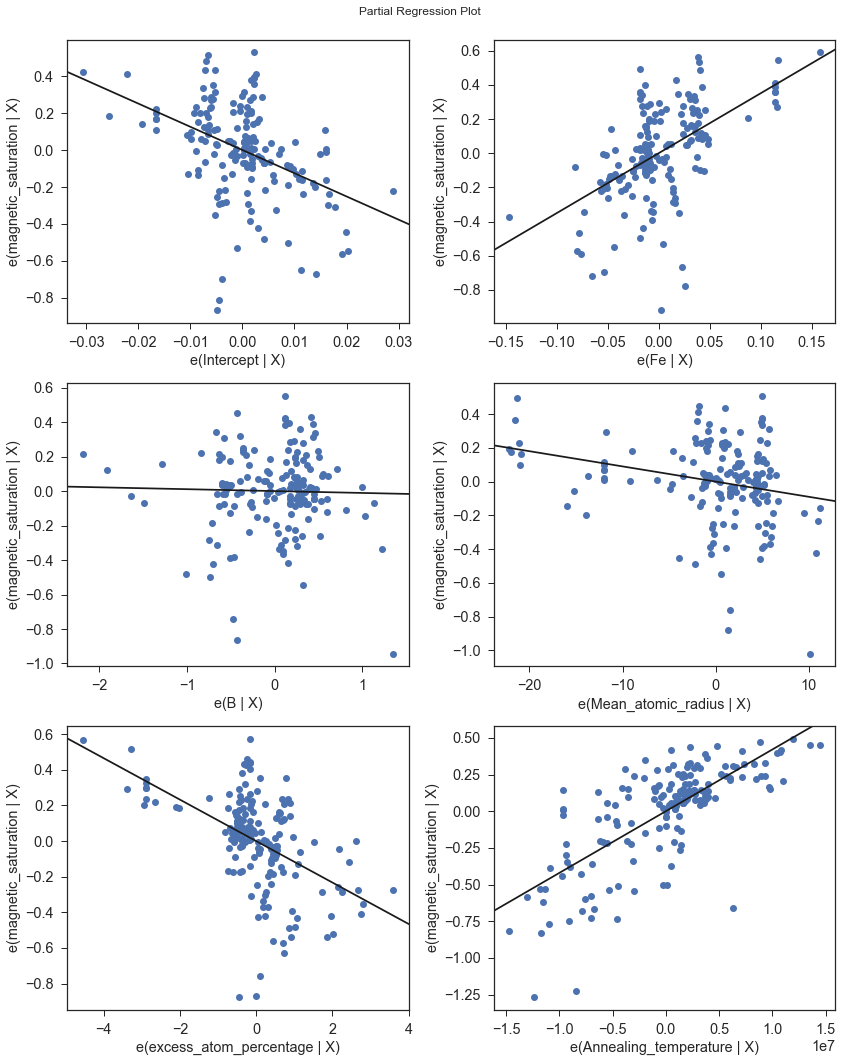

In [334]:
header=list(magsatextransselect.columns.values)
lmstr=header[-1]+" ~ "+header[0]
for i in range(len(header)-2):
    lmstr=lmstr+'+'+header[i+1]
mod = ols(lmstr,data=magsatextransselect).fit()
params = {'legend.fontsize': 'x-large',
          'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
fig = plt.figure(figsize=(12,15))
fig = sm.graphics.plot_partregress_grid(mod, fig=fig)

#### Influential plot using cooks distance

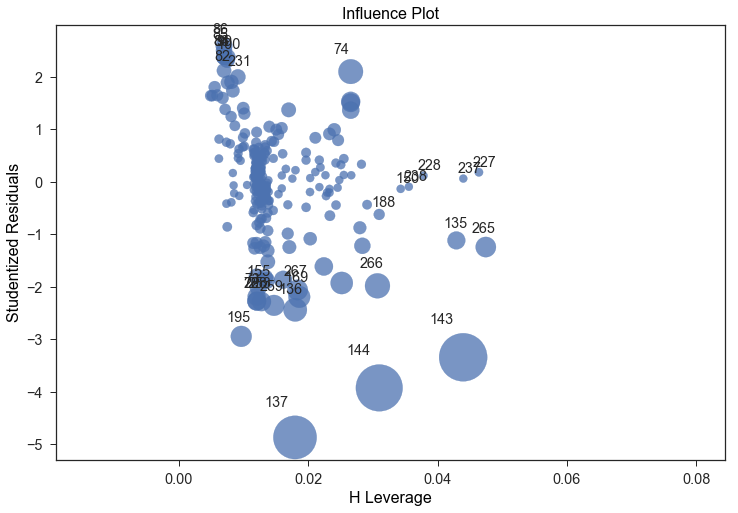

In [320]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(mod, ax=ax, criterion="Cooks") 

##### Get rid of high leverage point and remodel

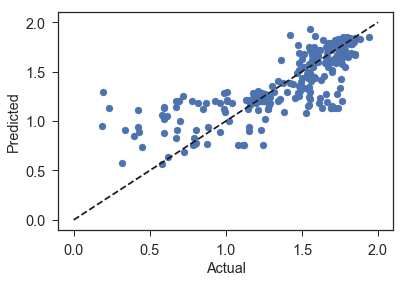

In [321]:
#magsatextransselect=magsatextransselect.drop(magsatextransselect.index[[78,77,72]])
mod = ols(lmstr,data=magsatextransselect).fit()
Y=magsatextransselect['magnetic_saturation'].as_matrix()
fig,ax = plt.subplots()
ax.scatter(Y,mod.fittedvalues)
ax.plot([0,2],[0,2],'k--')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

#### Print coeficients of regression expression of magnetic saturation with early transition metal

In [179]:
print(mod.params)
moddict['magsat_ex']=[mod,lams,'none']

Intercept                -1.347811e+01
Fe                        3.658863e+00
B                        -3.372230e-05
Mean_atomic_radius       -7.421435e-03
excess_atom_percentage   -1.179207e-01
Annealing_temperature     4.004640e-08
dtype: float64


### Analyzing magnetic saturation without early transition metal

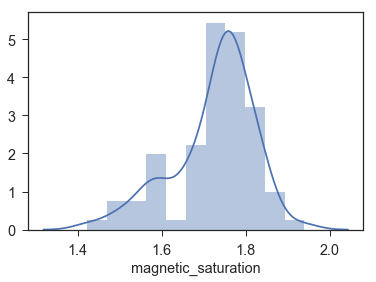

In [180]:
magsatnonex=magsatdg[0]
sns.distplot(magsatnonex['magnetic_saturation'])

#### plot magnetic saturation with predictors (no early transition metal)

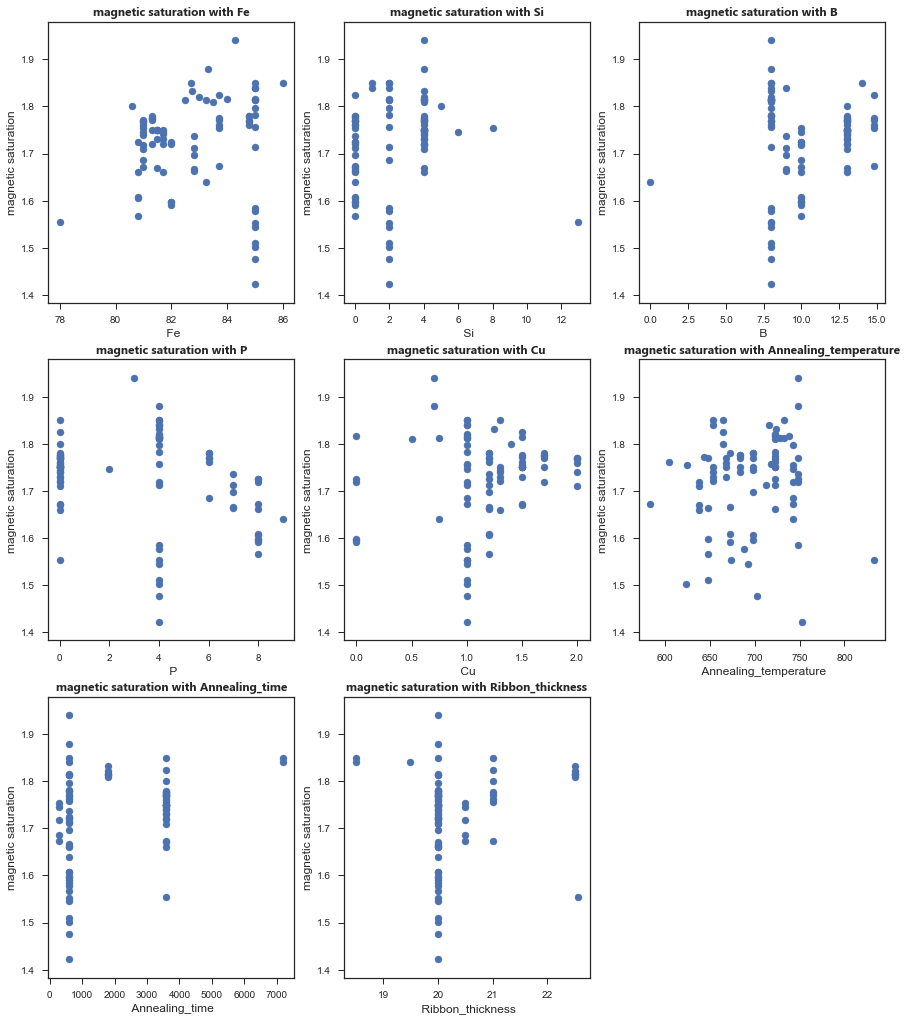

In [181]:
header=list(magsatnonex.columns.values)
designmatrix=magsatnonex.as_matrix()
params = {'legend.fontsize': 'medium',
          'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)
# drop colums that have less than 4 distinct values
for j in range(len(header)):
    a=magsatnonex[header[j]].nunique(dropna=True)
    if a<4:
        magsatnonex=magsatnonex.drop(columns=[header[j]])
magsatnonex=magsatnonex.reset_index(drop=True)
header=list(magsatnonex.columns.values)
designmatrix=magsatnonex.as_matrix()
fig = plt.figure(figsize=(15,30))
for i in range(np.size(designmatrix,1)-1):
    ax = fig.add_subplot(5,3,i+1)
    ax.scatter(designmatrix[:,i],designmatrix[:,-1],marker="o", s=50)
    ax.set_xlabel(" %s"%header[i],fontsize=12, fontweight='normal')
    ax.set_ylabel("magnetic saturation",fontsize=12, fontweight='normal')
    ax.set_title("magnetic saturation with %s"%header[i], fontweight='bold', fontsize=12, fontname='Segoe UI')

#### Box cox transformation

In [182]:
indexes=[0]
dataset=magsatnonex
magsatnonextrans,lams=box_cox(dataset,indexes)
lamsframe=pd.DataFrame.from_dict(lams,orient='index')
writer = pd.ExcelWriter('boxcox_magsatnonex.xlsx')
lamsframe.to_excel(writer,'magnetic saturation')
writer.save()

#### Pair plot for transformed dataset

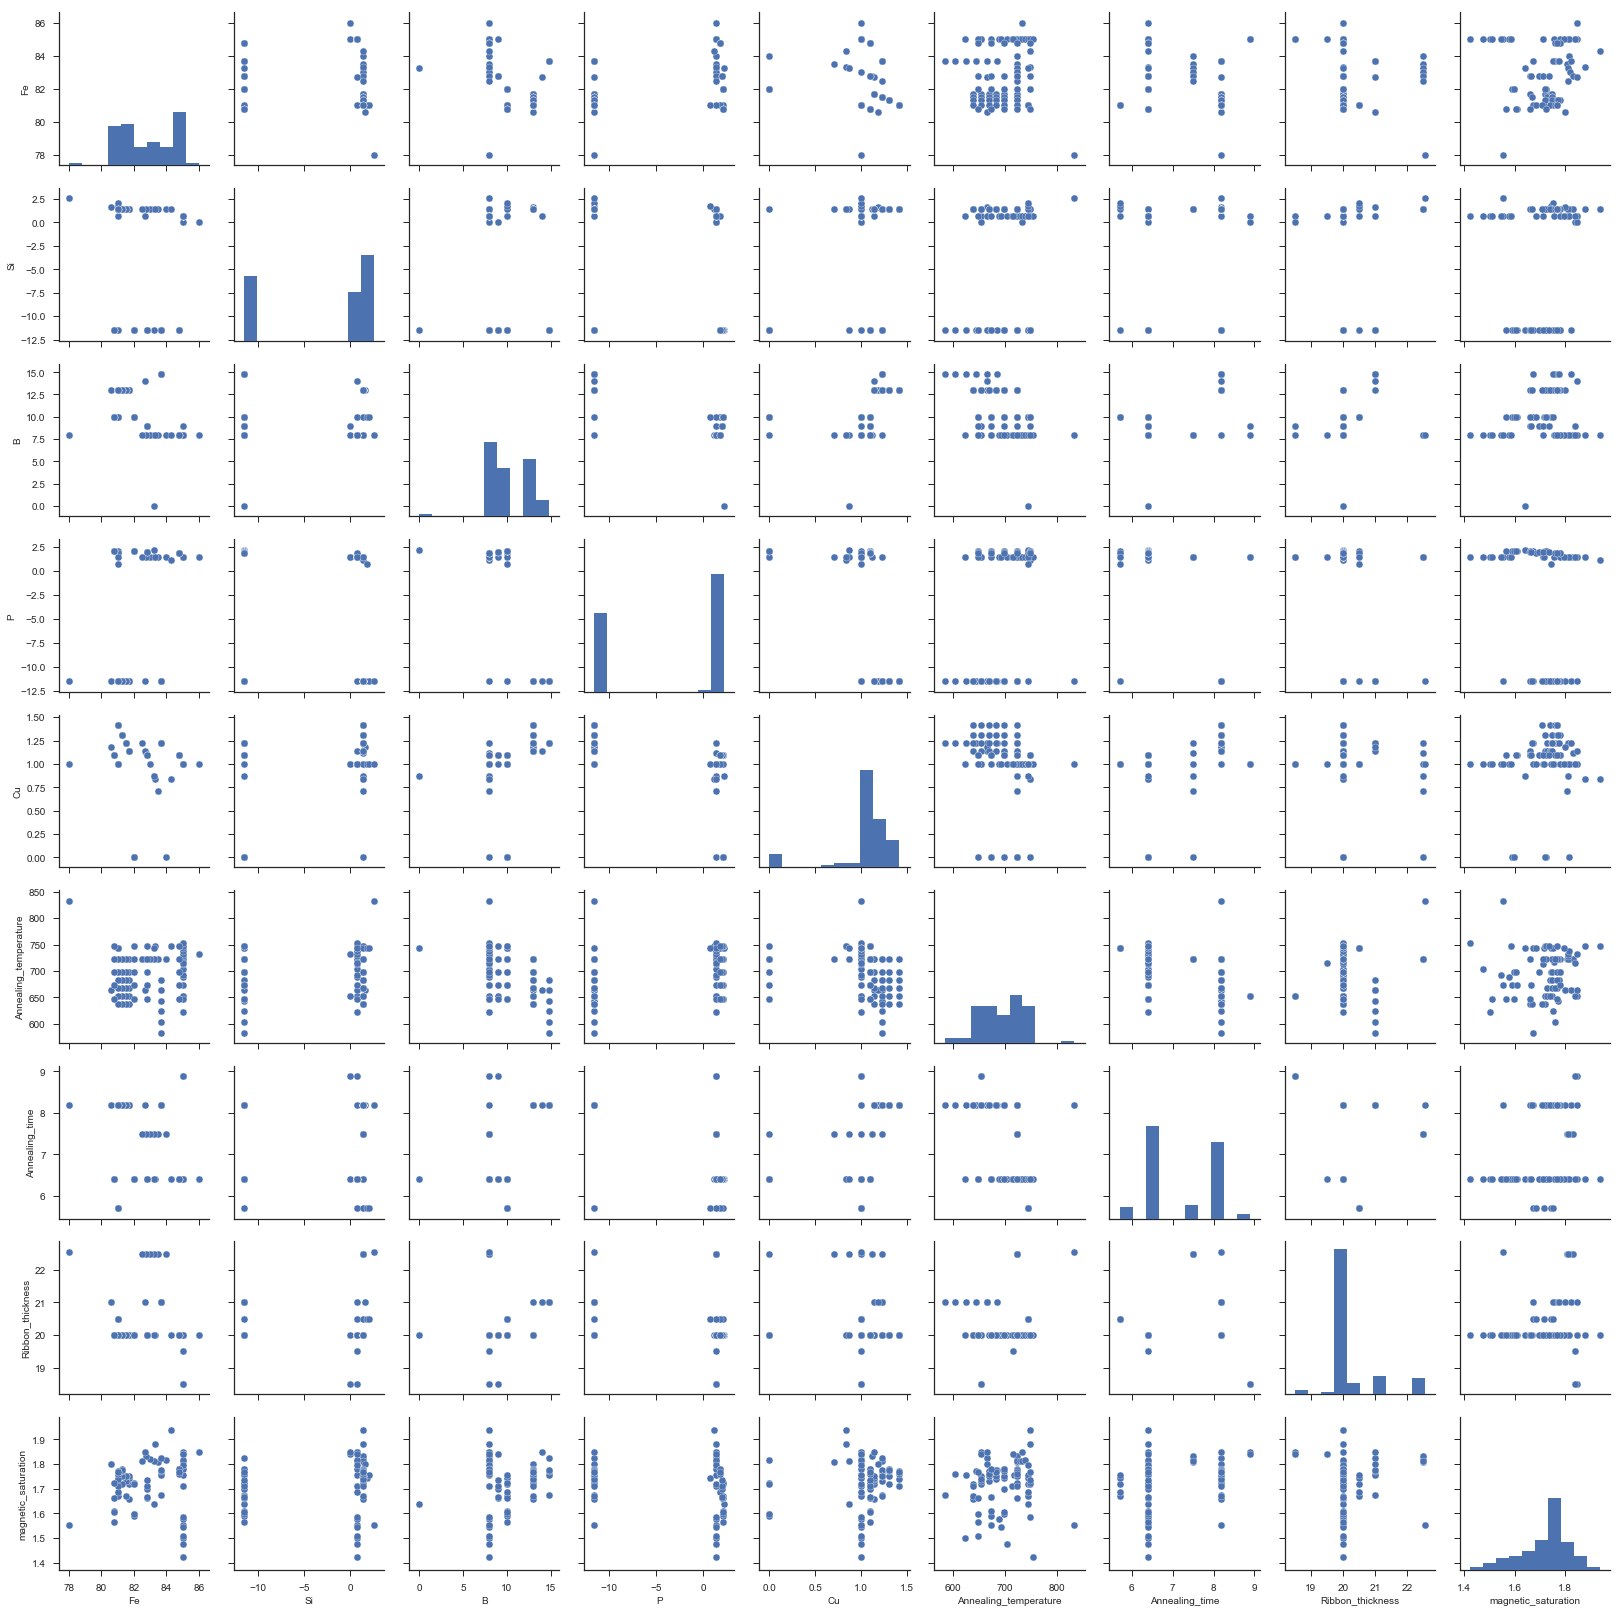

In [183]:
sns.pairplot(magsatnonextrans)

#### Model build and Partial regression plot

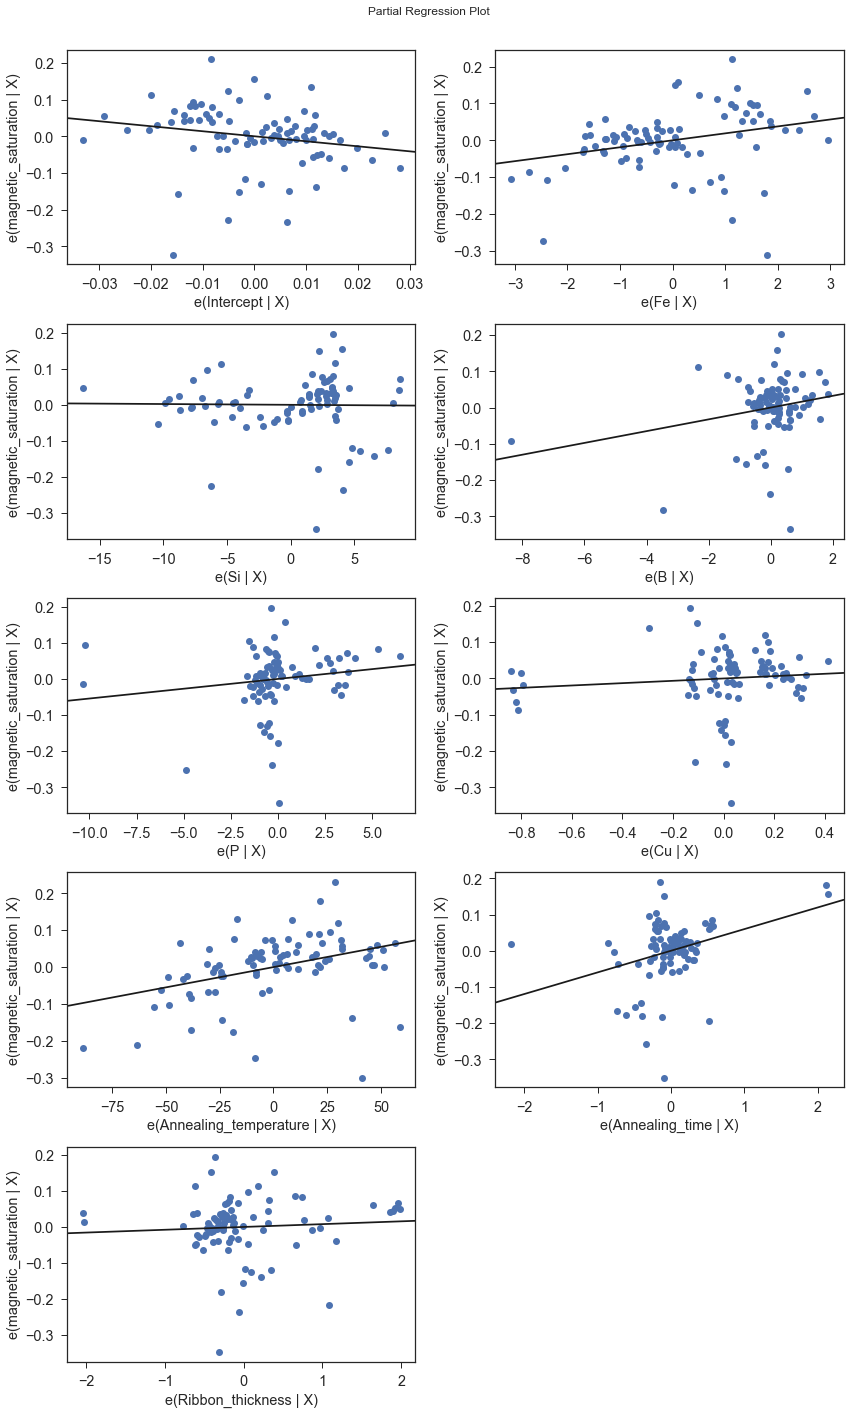

In [184]:
header=list(magsatnonextrans.columns.values)
lmstr=header[-1]+" ~ "+header[0]
for i in range(len(header)-2):
    lmstr=lmstr+'+'+header[i+1]
mod = ols(lmstr,data=magsatnonextrans).fit()
params = {'legend.fontsize': 'x-large',
          'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
fig = plt.figure(figsize=(12,20))
fig = sm.graphics.plot_partregress_grid(mod, fig=fig)

#### Drop Si based on partial regression plot

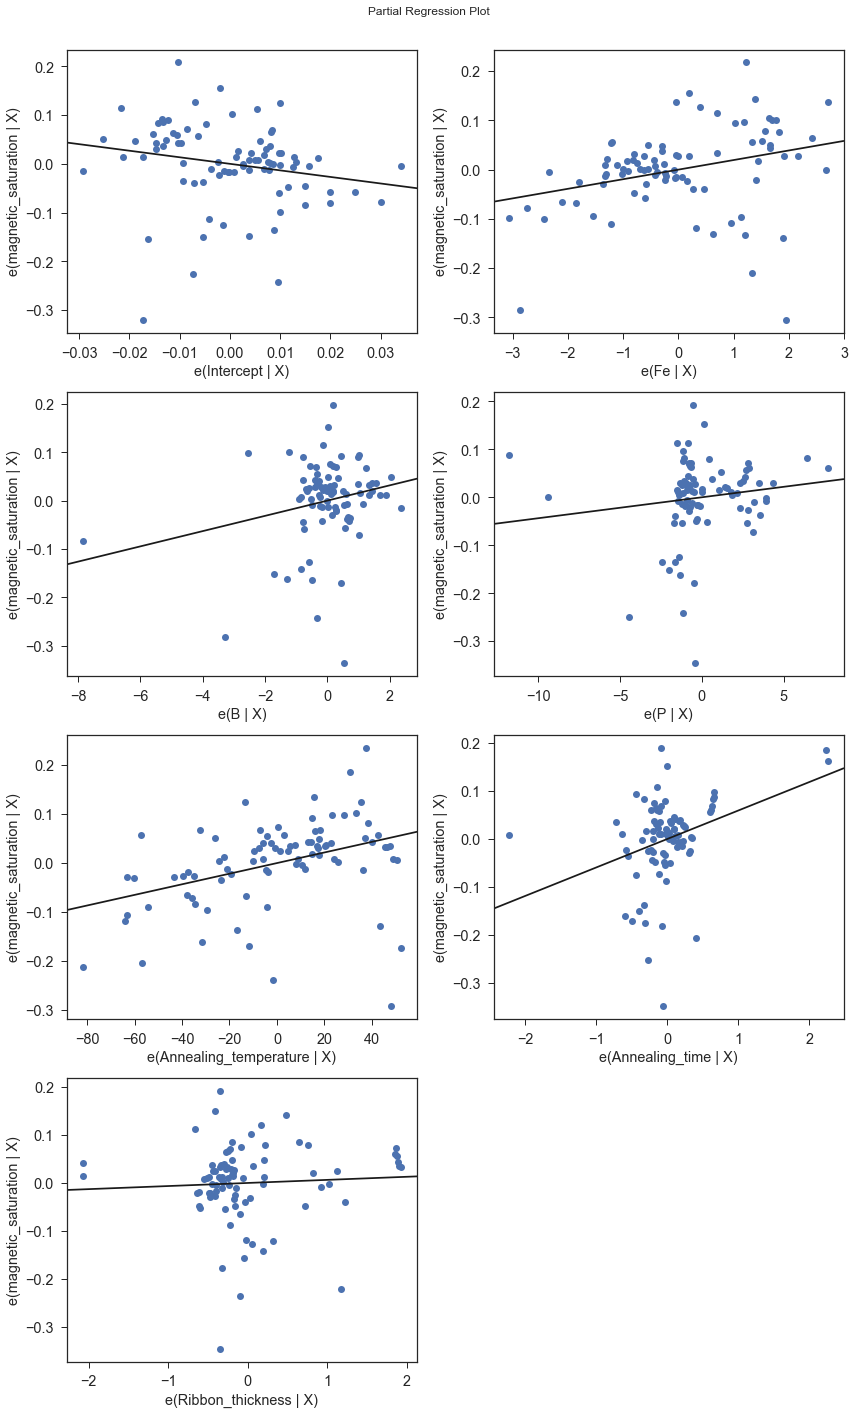

In [185]:
magsatnonextransselect=magsatnonextrans.drop(columns=['Si','Cu']).reset_index(drop=True)
header=list(magsatnonextransselect.columns.values)
lmstr=header[-1]+" ~ "+header[0]
for i in range(len(header)-2):
    lmstr=lmstr+'+'+header[i+1]
mod = ols(lmstr,data=magsatnonextransselect).fit()
params = {'legend.fontsize': 'x-large',
          'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
fig = plt.figure(figsize=(12,20))
fig = sm.graphics.plot_partregress_grid(mod, fig=fig)

#### Influential plot using cooks distance

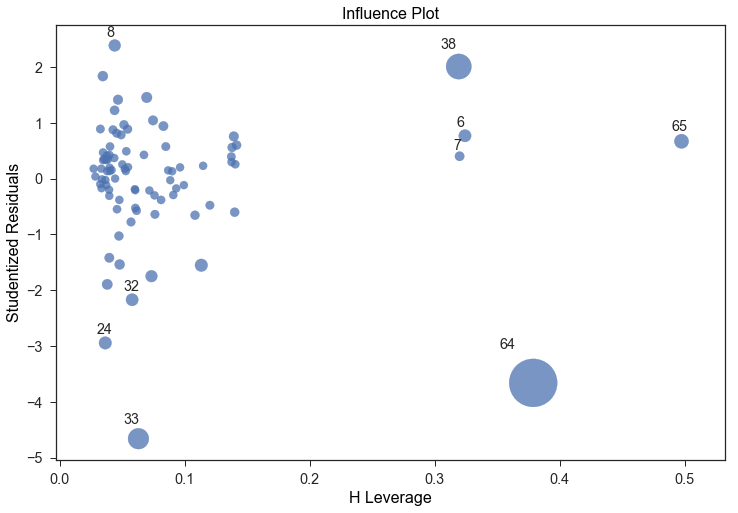

In [186]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(mod, ax=ax, criterion="Cooks") 

##### Get rid of high leverage point and remodel

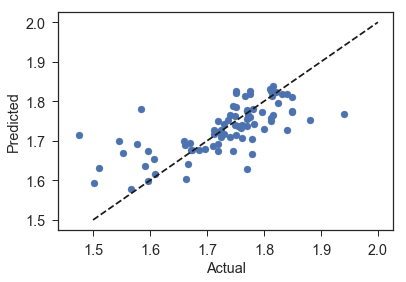

In [187]:
magsatnonextransselect=magsatnonextransselect.drop(magsatnonextransselect.index[[64,65,33,38]])
mod = ols(lmstr,data=magsatnonextransselect).fit()
Y=magsatnonextransselect['magnetic_saturation'].as_matrix()
fig,ax = plt.subplots()
ax.scatter(Y,mod.fittedvalues)
ax.plot([1.5,2],[1.5,2],'k--')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

#### Print model coeficients

In [188]:
print(mod.params)
moddict['magsat_nonex']=[mod,lams,'none']

Intercept               -1.536352
Fe                       0.016696
B                        0.007910
P                        0.003043
Annealing_temperature    0.001490
Annealing_time           0.076323
Ribbon_thickness         0.011380
dtype: float64


### Analyzing core loss

core loss data size
(34, 15)


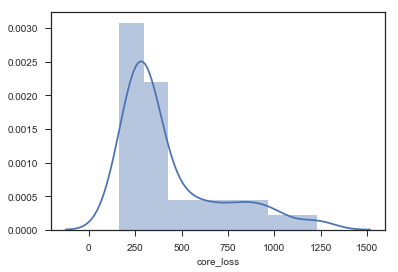

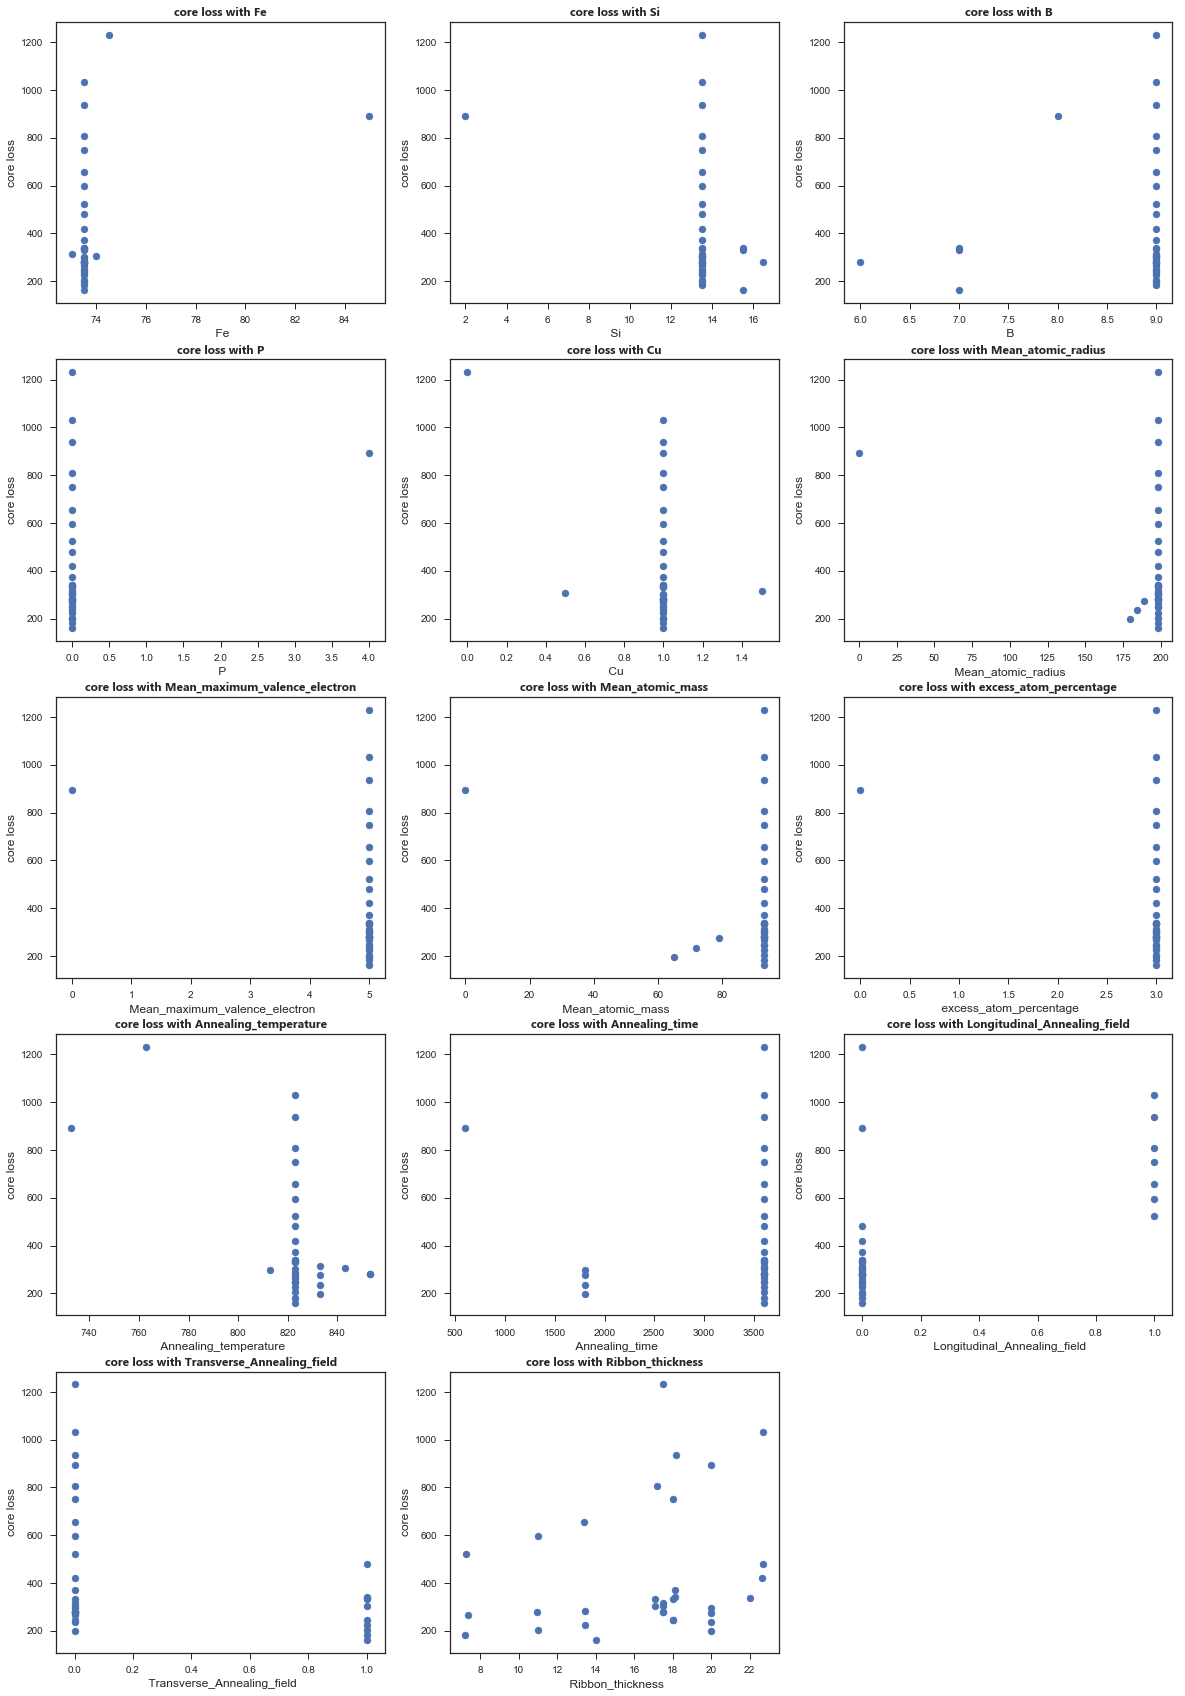

In [189]:
corelossdata=modeldatas['core_loss']
n=corelossdata.shape[0]
corelossdata=corelossdata.dropna(axis=1,thresh=int(0.4*n))
corelossdata=corelossdata.fillna(corelossdata.mean())
header=list(corelossdata.columns.values)
indexes=[]
indexes.append(header.index('Longitudinal_Annealing_field'))
indexes.append(header.index('Transverse_Annealing_field'))
designmatrix=corelossdata.as_matrix()
params = {'legend.fontsize': 'medium',
          'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)
sns.distplot(corelossdata['core_loss'])
fig = plt.figure(figsize=(20,30))
for i in range(np.size(designmatrix,1)-1):
    ax = fig.add_subplot(5,3,i+1)
    ax.scatter(designmatrix[:,i],designmatrix[:,-1],marker="o", s=50)
    ax.set_xlabel(" %s"%header[i],fontsize=12, fontweight='normal')
    ax.set_ylabel("core loss",fontsize=12, fontweight='normal')
    ax.set_title("core loss with %s"%header[i], fontweight='bold', fontsize=12, fontname='Segoe UI')
    #plt.savefig("Figure2_{y}.png".format(y=header[i]),dpi=500)
n=corelossdata.shape
print('core loss data size')
print(n)

#### Making full model based on all predictors

In [190]:
header=list(corelossdata.columns.values)
lmstr=header[-1]+" ~ "+header[0]
for i in range(len(header)-2):
    lmstr=lmstr+'+'+header[i+1]
mod = ols(lmstr,data=corelossdata).fit()


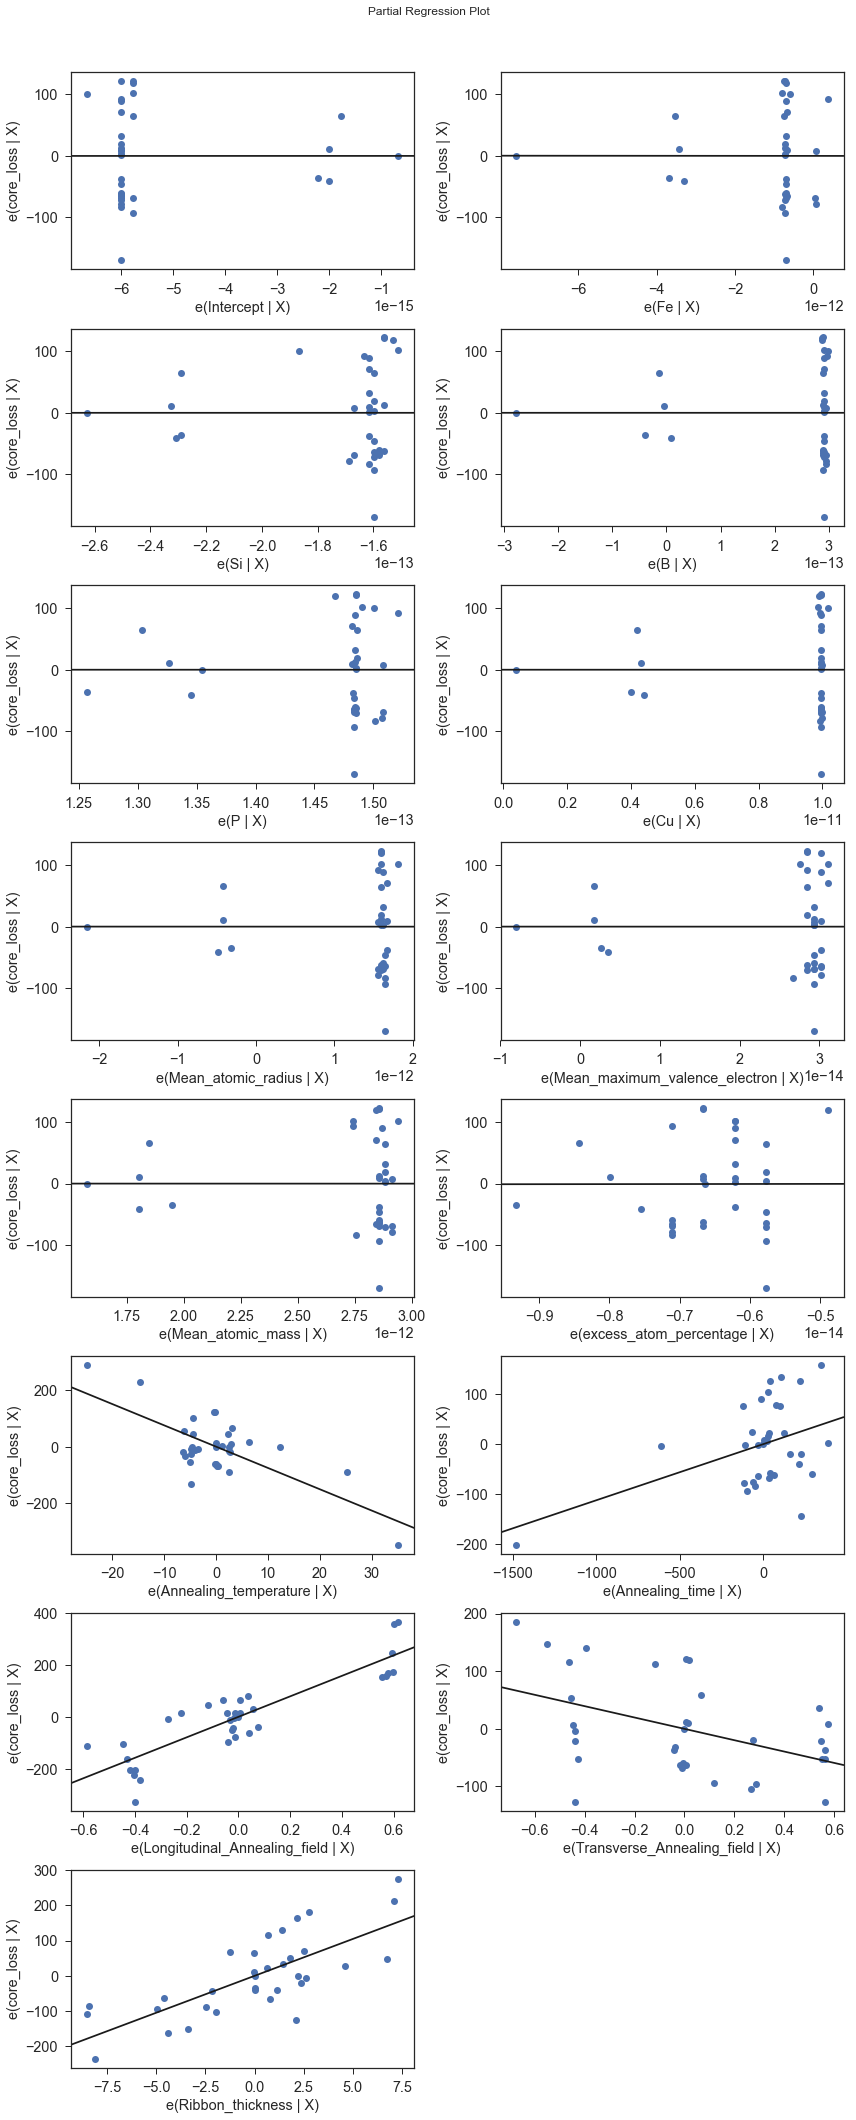

In [192]:
params = {'legend.fontsize': 'x-large',
          'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
fig = plt.figure(figsize=(12,30))
fig = sm.graphics.plot_partregress_grid(mod, fig=fig)

#### Retain only four predictors based on partial regression plot

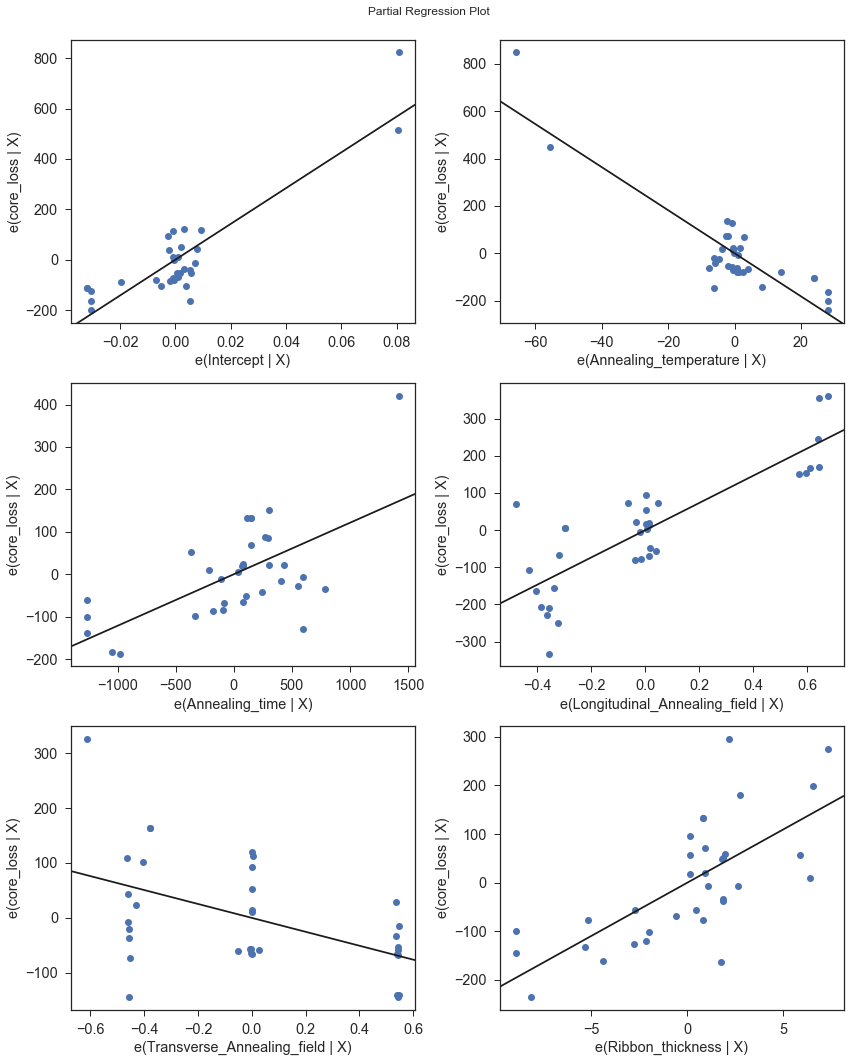

In [193]:
corelossdataselect=corelossdata[['Annealing_temperature','Annealing_time','Longitudinal_Annealing_field', \
                                 'Transverse_Annealing_field','Ribbon_thickness','core_loss']].reset_index(drop=True)
header=list(corelossdataselect.columns.values)
lmstr=header[-1]+" ~ "+header[0]
for i in range(len(header)-2):
    lmstr=lmstr+'+'+header[i+1]
mod = ols(lmstr,data=corelossdataselect).fit()
params = {'legend.fontsize': 'x-large',
          'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
fig = plt.figure(figsize=(12,15))
fig = sm.graphics.plot_partregress_grid(mod, fig=fig)

#### Influential plot using cooks distance

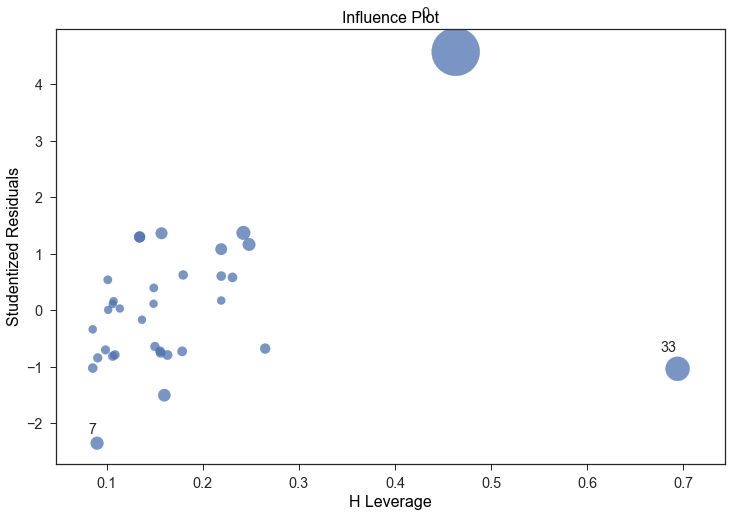

In [194]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(mod, ax=ax, criterion="Cooks") 

#### Get rid of high leverage data and remodel

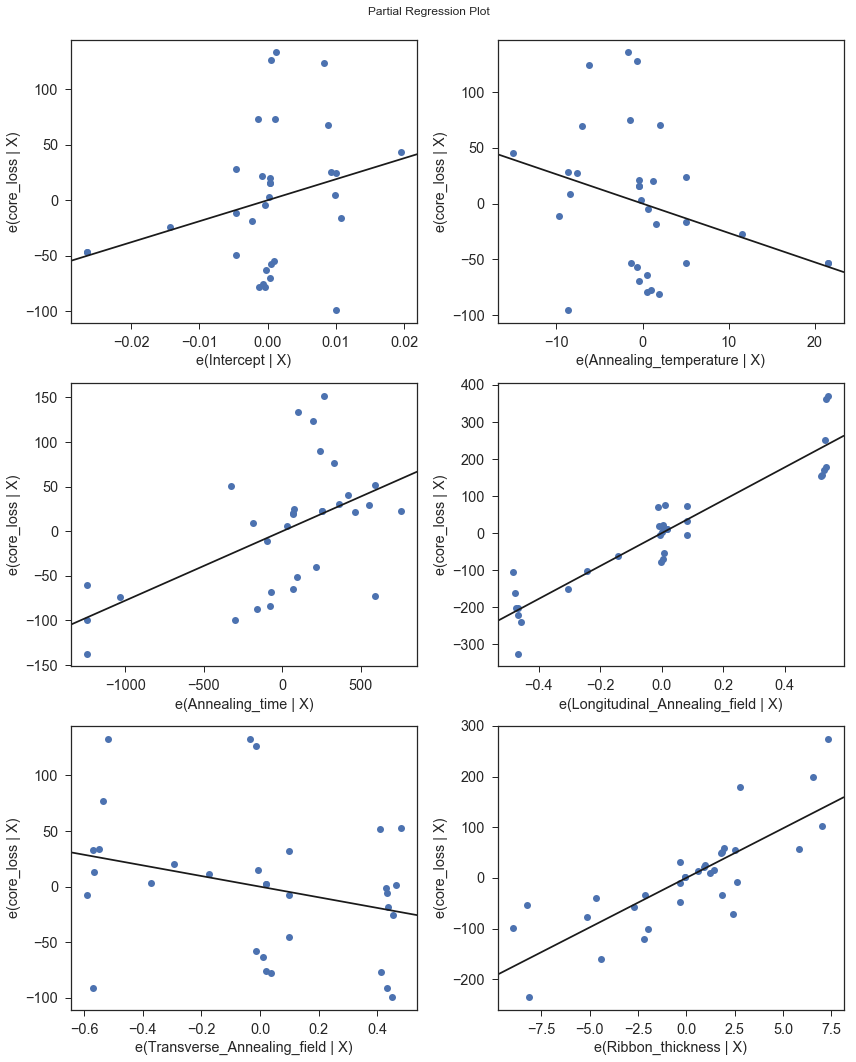

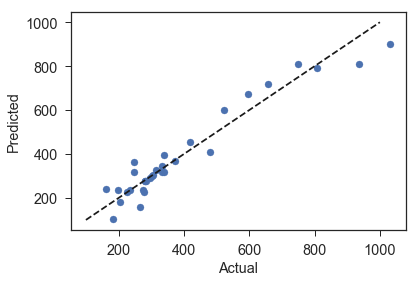

In [195]:
corelossdataselect=corelossdataselect.drop(corelossdataselect.index[[0,33]])
mod = ols(lmstr,data=corelossdataselect).fit()
Y=corelossdataselect['core_loss'].as_matrix()
fig,ax = plt.subplots()
ax.scatter(Y,mod.fittedvalues)
ax.plot([100,1000],[100,1000],'k--')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

#### Print coeficients of regression expression

In [196]:
print(mod.params)
moddict['core_loss']=[mod,'none','none']

Intercept                       1895.603071
Annealing_temperature             -2.628115
Annealing_time                     0.077783
Longitudinal_Annealing_field     443.670226
Transverse_Annealing_field       -47.862384
Ribbon_thickness                  19.576936
dtype: float64


### Analyzing Permeability

Number of data entries:
296


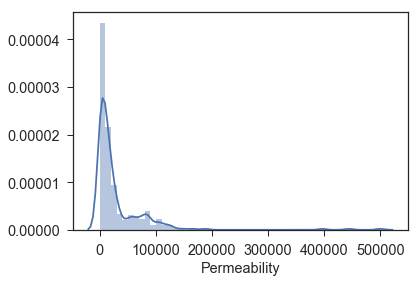

In [197]:
permdata=modeldatas['Permeability']
n=permdata.shape[0]
permdata=permdata.dropna(axis=1,thresh=int(0.4*n))
permdata=permdata.fillna(permdata.mean())
sns.distplot(permdata['Permeability'])
print('Number of data entries:')
print(n)

#### Taking natural log transformation on Permeability

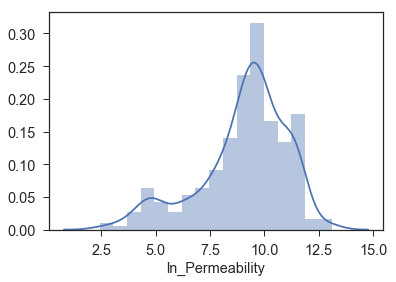

In [198]:
header=list(permdata.columns.values)
indexes=[]
indexes.append(header.index('Longitudinal_Annealing_field'))
indexes.append(header.index('Transverse_Annealing_field'))
permdata['time_div_temp']=np.multiply(np.power(permdata['Annealing_temperature'],-1),permdata['Annealing_time'])
permdata['ln_Permeability']=pd.Series(np.log(permdata['Permeability']), index=permdata.index)
permdata=permdata.drop(columns=['Permeability']).reset_index(drop=True)
sns.distplot(permdata['ln_Permeability'])

#### Show range count

In [199]:
ranges = [2,3,4,5,6,7,8,9,10,11,12,13,14]
groupd=permdata.groupby(pd.cut(permdata['ln_Permeability'], ranges)).count()
groupd=groupd['ln_Permeability']
print(groupd)

ln_Permeability
(2, 3]       2
(3, 4]       4
(4, 5]      17
(5, 6]       9
(6, 7]      14
(7, 8]      22
(8, 9]      44
(9, 10]     91
(10, 11]    43
(11, 12]    45
(12, 13]     3
(13, 14]     2
Name: ln_Permeability, dtype: int64


#### Building classifier to differentiate low permeability and high permeability, (2,8] is low permeability and (8,14] is high permeability.

In [200]:
# split the dataset
ranges = [2,8,14]
groupb=permdata.groupby(pd.cut(permdata['ln_Permeability'], ranges))
permdg=[groupb.get_group(x) for x in groupb.groups]
permdg[0]['permind']=pd.Series(0,index=permdg[0].index)
permdg[1]['permind']=pd.Series(1,index=permdg[1].index)
permclass=pd.concat(permdg)
permclass=permclass.drop(columns=['ln_Permeability']).copy().reset_index(drop=True)
clf = SVC(kernel='sigmoid',class_weight='balanced')
scores=cross_val_score(clf, permclass.drop(columns=['permind']), permclass['permind'], cv=10)
print("SVM classifier Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
clf2= DTC(random_state=0,class_weight='balanced')
scores=cross_val_score(clf2, permclass.drop(columns=['permind']), permclass['permind'], cv=10)
print("Decision tree classifier Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

SVM classifier Accuracy: 0.77 (+/- 0.02)
Decision tree classifier Accuracy: 0.70 (+/- 0.23)


In [201]:
clf.fit(permclass.drop(columns=['permind']), permclass['permind'])
moddict['permeability_classifier']=[clf,'none','ln(Y)']

#### Build regression model for low permeability

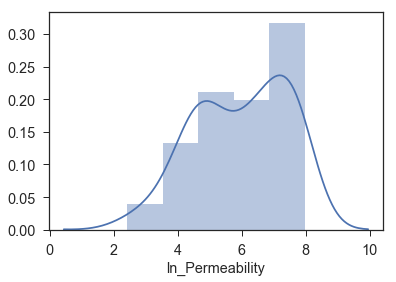

In [202]:
permlow=permdg[0].copy()
sns.distplot(permlow['ln_Permeability'])

#### Pair plot of ln_Permeability

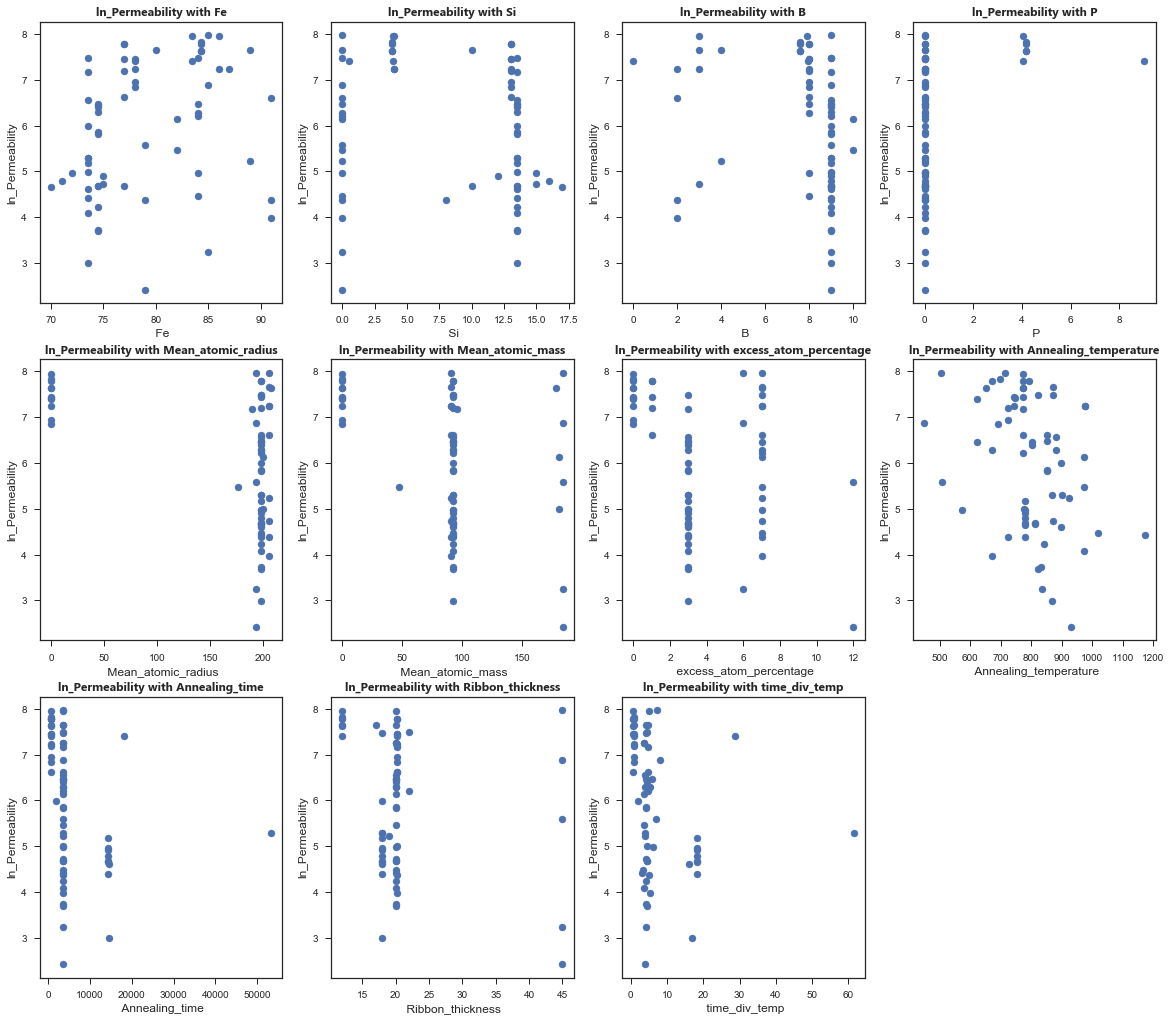

In [203]:
# drop colums that have less than 5 distinct values
header=list(permlow.columns.values)
for j in range(len(header)):
    a=permlow[header[j]].nunique(dropna=True)
    if a<5:
        permlow=permlow.drop(columns=[header[j]])
# ploting params
params = {'legend.fontsize': 'medium',
          'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)
header=list(permlow.columns.values)
designmatrix=permlow.as_matrix()
fig = plt.figure(figsize=(20,30))
for i in range(np.size(designmatrix,1)-1):
    ax = fig.add_subplot(5,4,i+1)
    ax.scatter(designmatrix[:,i],designmatrix[:,-1],marker="o", s=50)
    ax.set_xlabel(" %s"%header[i],fontsize=12, fontweight='normal')
    ax.set_ylabel("ln_Permeability",fontsize=12, fontweight='normal')
    ax.set_title("ln_Permeability with %s"%header[i], fontweight='bold', fontsize=12, fontname='Segoe UI')
    #plt.savefig("Figure2_{y}.png".format(y=header[i]),dpi=500)

#### Box cox transformation

In [204]:
indexes=[]
dataset=permlow
permlowtrans,lams=box_cox(dataset,indexes)
lamsframe=pd.DataFrame.from_dict(lams,orient='index')
writer = pd.ExcelWriter('boxcox_permeability_low.xlsx')
lamsframe.to_excel(writer,'permeability')
writer.save()

#### Building OLS model

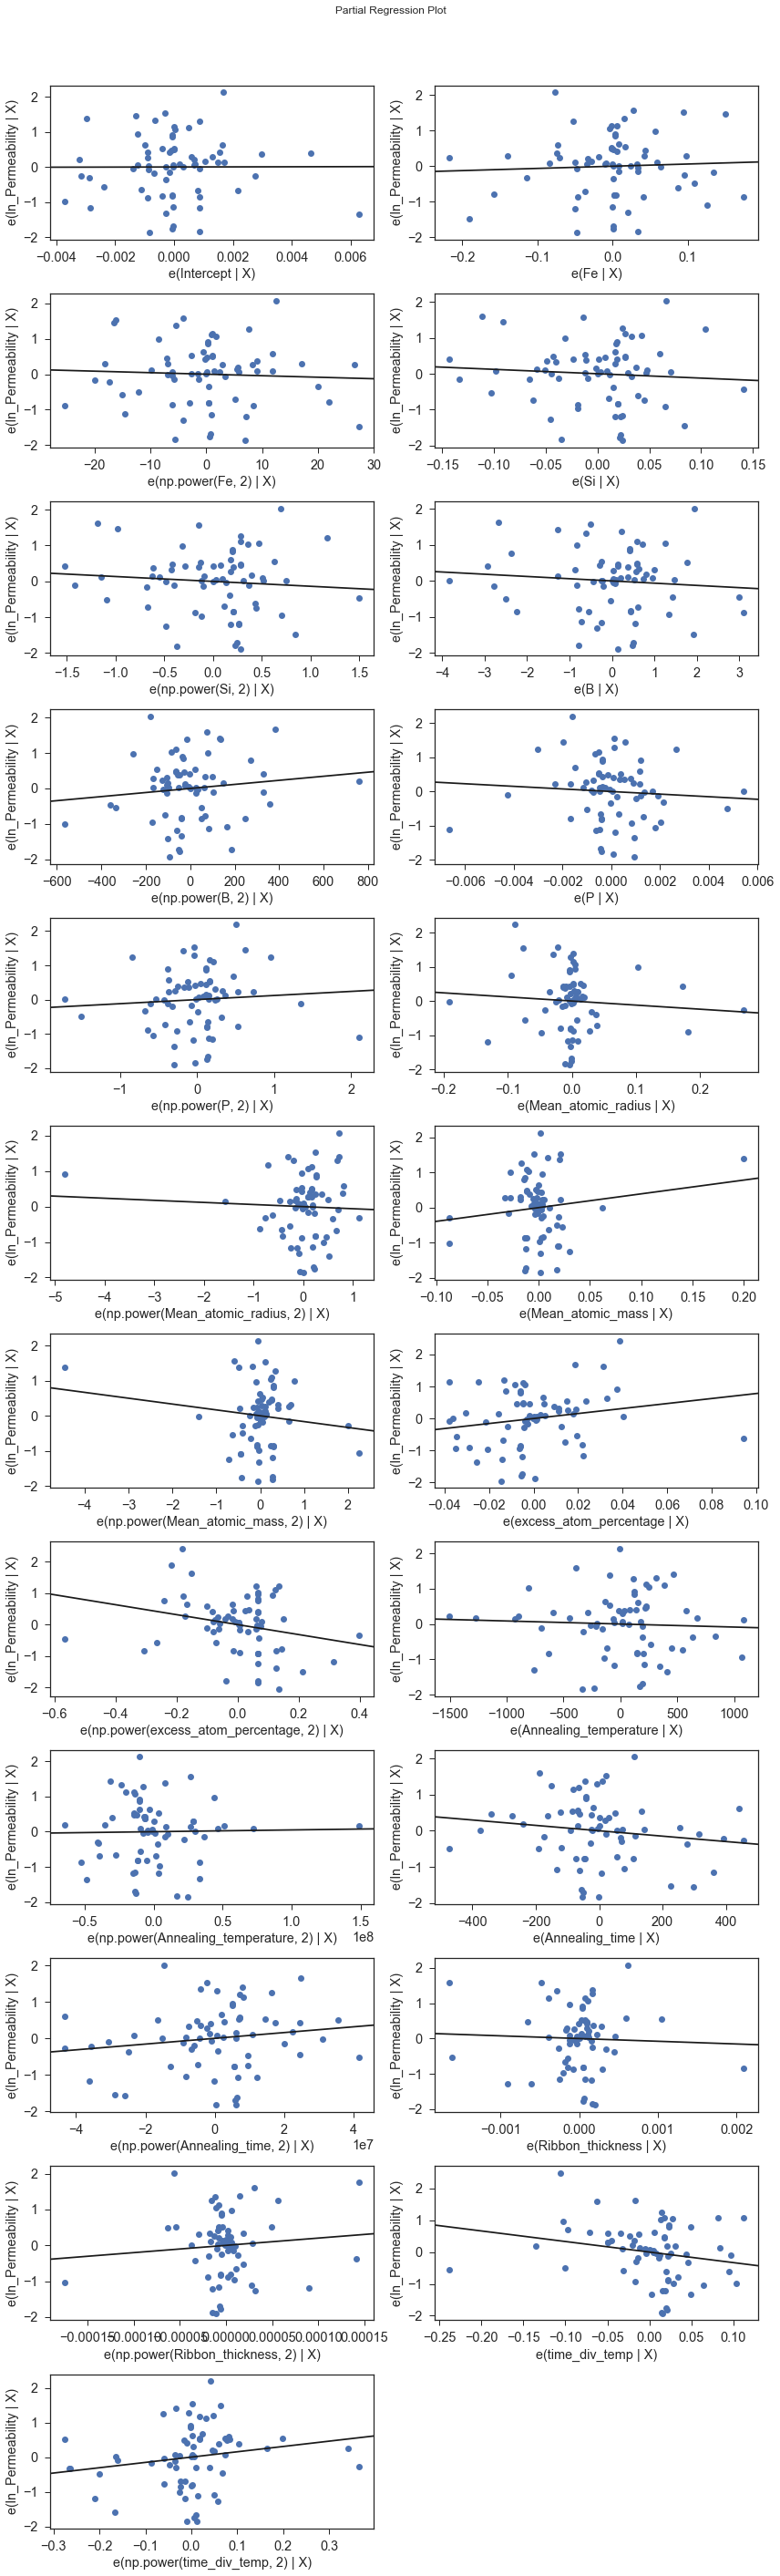

In [206]:
permlowtrans=permlowtrans.reset_index(drop=True)
header=list(permlowtrans.columns.values)
lmstr=header[-1]+" ~ "+header[0]+" + "+"np.power("+header[0]+",2)"
for i in range(len(header)-2):
    lmstr=lmstr+'+'+header[i+1]+" + "+"np.power("+header[i+1]+",2)"
mod = sm.RLM.from_formula(lmstr,data=permlowtrans,M=sm.robust.norms.HuberT()).fit()
params = {'legend.fontsize': 'x-large',
          'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
fig = plt.figure(figsize=(12,40))
fig = sm.graphics.plot_partregress_grid(mod, fig=fig)

#### Get rid of non significant variables

In [207]:
permlowtransselect=permlowtrans.drop(columns=['Ribbon_thickness','excess_atom_percentage','Mean_atomic_mass','Mean_atomic_radius'])
header=list(permlowtransselect.columns.values)
lmstr=header[-1]+" ~ "+header[0]+" + "+"np.power("+header[0]+",2)"
for i in range(len(header)-2):
    lmstr=lmstr+'+'+header[i+1]+" + "+"np.power("+header[i+1]+",2)"
mod = sm.RLM.from_formula(lmstr,data=permlowtransselect,M=sm.robust.norms.HuberT()).fit()


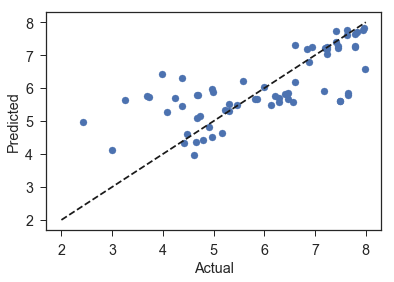

In [208]:
Ynew=permlowtransselect['ln_Permeability']
fig,ax = plt.subplots()
ax.scatter(Ynew,mod.fittedvalues)
ax.plot([2,8],[2,8],'k--')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

#### Print out model coeficients

In [210]:
print(mod.params)
moddict['permeability_low']=[mod,lams,'ln(Y)']

Intercept                             2.629133e+01
Fe                                   -4.797418e-01
np.power(Fe, 2)                       3.294944e-03
Si                                   -8.508315e-01
np.power(Si, 2)                      -1.000138e-01
B                                    -1.777859e-02
np.power(B, 2)                        2.474782e-04
P                                    -8.140841e-01
np.power(P, 2)                        2.583259e-03
Annealing_temperature                 6.576232e-05
np.power(Annealing_temperature, 2)   -2.038321e-09
Annealing_time                       -5.508901e-04
np.power(Annealing_time, 2)           6.348080e-09
time_div_temp                        -1.005023e+00
np.power(time_div_temp, 2)            7.892637e-01
dtype: float64


### Analyze the permeability in the range where ln(permeability) is (8,14]

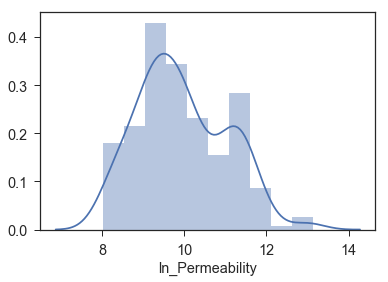

In [211]:
permhigh=permdg[1].copy()
sns.distplot(permhigh['ln_Permeability'])

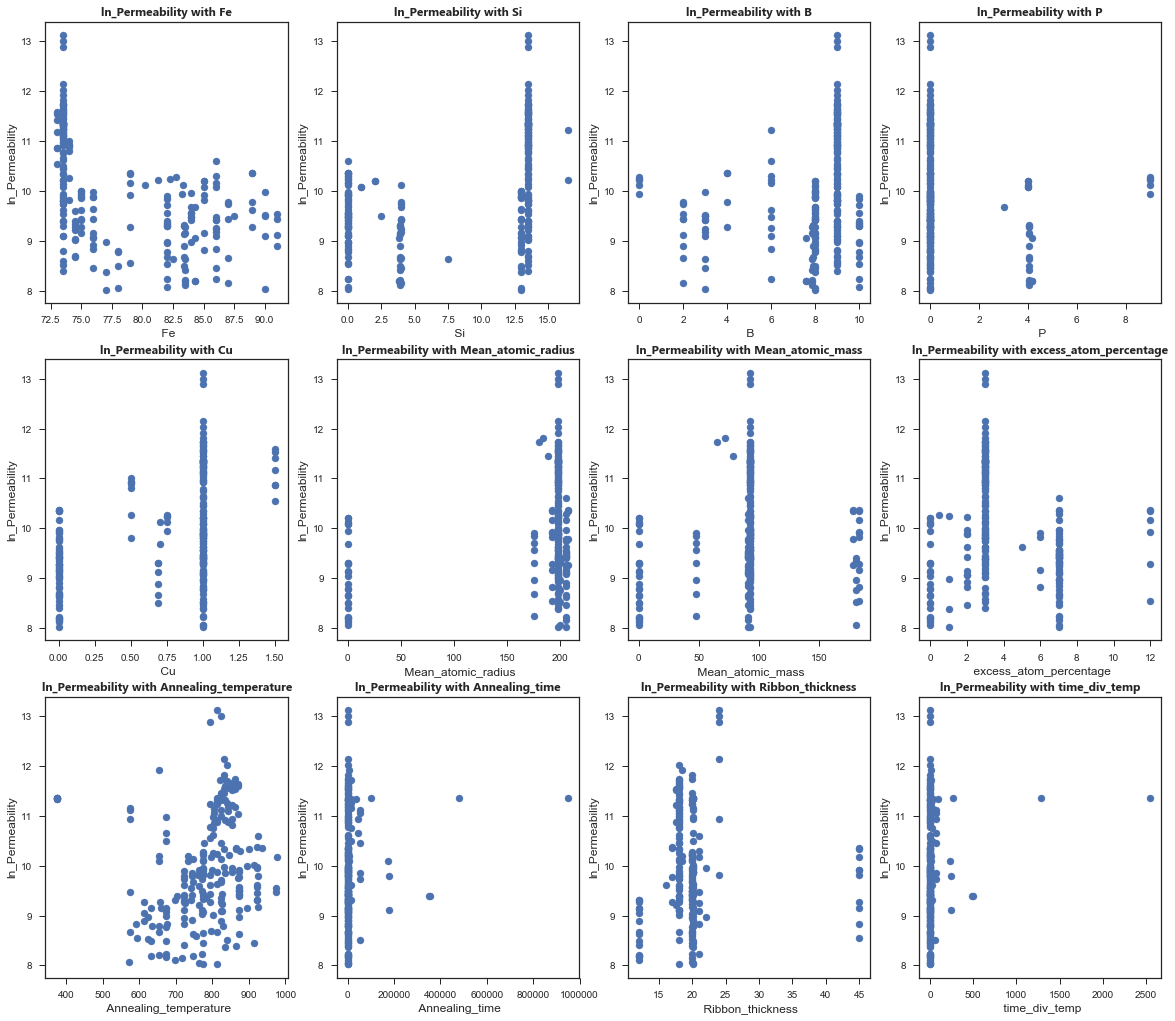

In [212]:
# drop colums that have less than 5 distinct values
header=list(permhigh.columns.values)
for j in range(len(header)):
    a=permhigh[header[j]].nunique(dropna=True)
    if a<5:
        permhigh=permhigh.drop(columns=[header[j]])
# ploting params
params = {'legend.fontsize': 'medium',
          'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)
header=list(permhigh.columns.values)
designmatrix=permhigh.as_matrix()
fig = plt.figure(figsize=(20,30))
for i in range(np.size(designmatrix,1)-1):
    ax = fig.add_subplot(5,4,i+1)
    ax.scatter(designmatrix[:,i],designmatrix[:,-1],marker="o", s=50)
    ax.set_xlabel(" %s"%header[i],fontsize=12, fontweight='normal')
    ax.set_ylabel("ln_Permeability",fontsize=12, fontweight='normal')
    ax.set_title("ln_Permeability with %s"%header[i], fontweight='bold', fontsize=12, fontname='Segoe UI')
    #plt.savefig("Figure2_{y}.png".format(y=header[i]),dpi=500)

In [213]:
indexes=[]
dataset=permhigh
permhightrans,lams=box_cox(dataset,indexes)
lamsframe=pd.DataFrame.from_dict(lams,orient='index')
writer = pd.ExcelWriter('boxcox_permeability_high.xlsx')
lamsframe.to_excel(writer,'permeability')
writer.save()

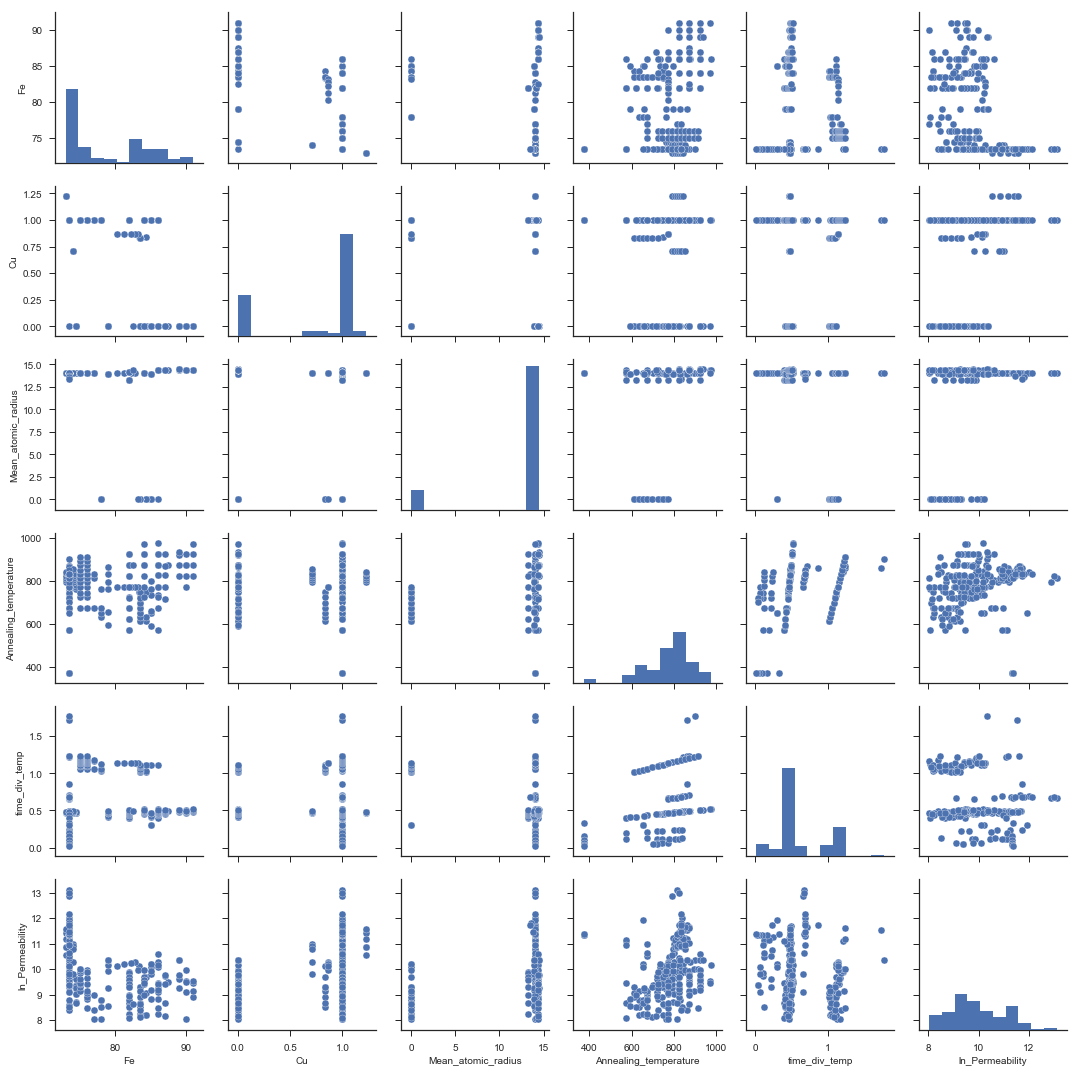

In [214]:
dataset=permhightrans
Y=permhightrans['ln_Permeability'].as_matrix()
X=permhightrans.drop(columns=['ln_Permeability']).as_matrix()
permhightransselect=lasso_bic(dataset,Y,X).reset_index(drop=True)
sns.pairplot(permhightransselect)

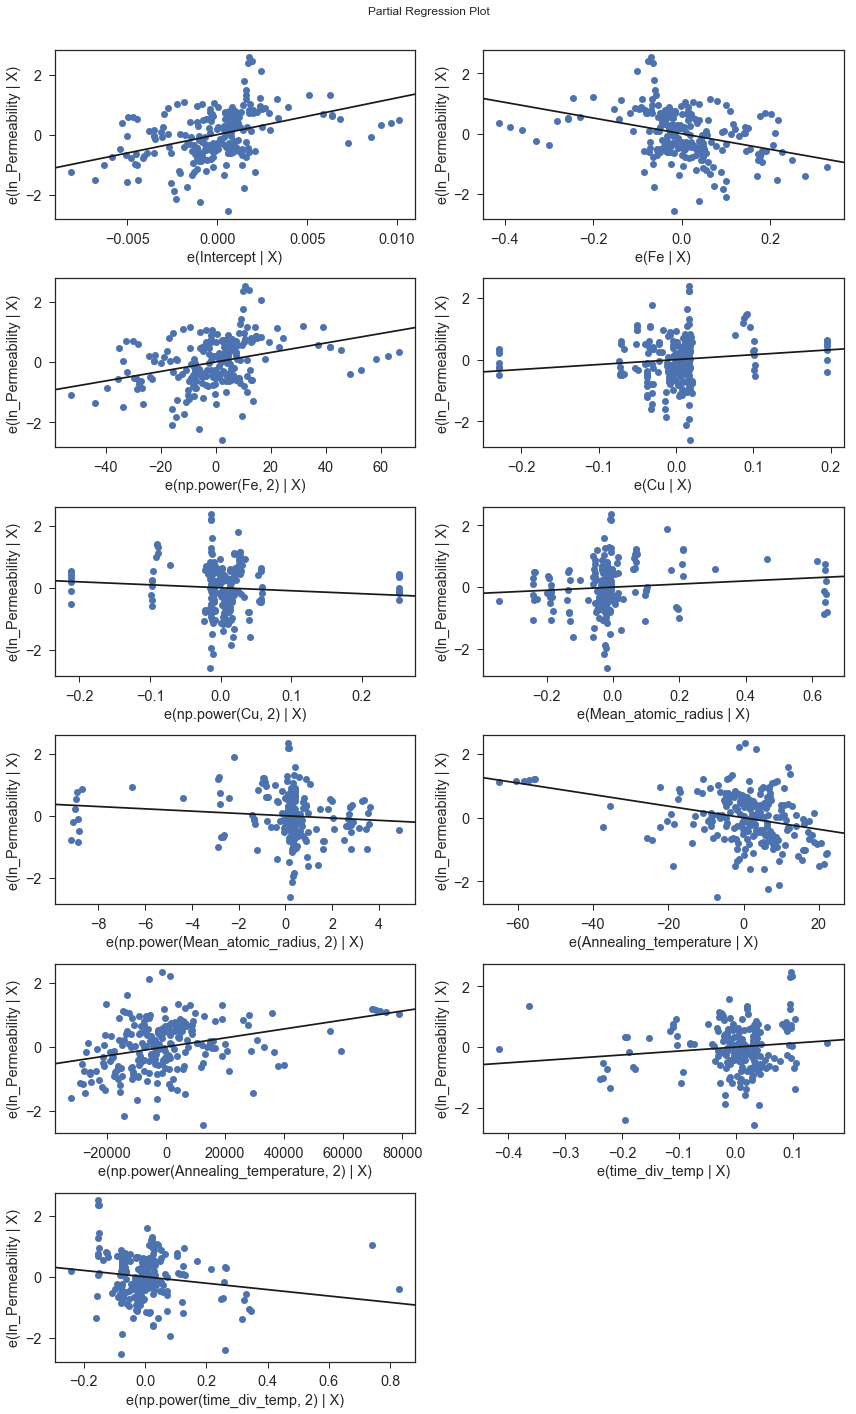

In [215]:
permhightransselect=permhightransselect.reset_index(drop=True)
header=list(permhightransselect.columns.values)
lmstr=header[-1]+" ~ "+header[0]+" + "+"np.power("+header[0]+",2)"
for i in range(len(header)-2):
    lmstr=lmstr+'+'+header[i+1]+" + "+"np.power("+header[i+1]+",2)"
mod = sm.RLM.from_formula(lmstr,data=permhightransselect,M=sm.robust.norms.HuberT()).fit()
params = {'legend.fontsize': 'x-large',
          'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
fig = plt.figure(figsize=(12,20))
fig = sm.graphics.plot_partregress_grid(mod, fig=fig)

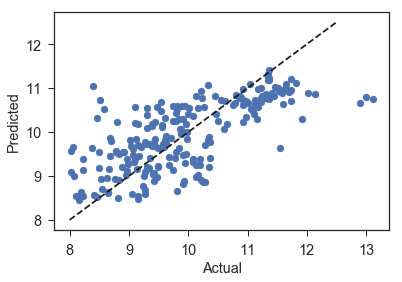

In [216]:
Ynew=permhightransselect['ln_Permeability']
fig,ax = plt.subplots()
ax.scatter(Ynew,mod.fittedvalues)
ax.plot([8,12.5],[8,12.5],'k--')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

In [217]:
print(mod.params)
moddict['permeability_high']=[mod,lams,'ln(Y)']

Intercept                             117.379908
Fe                                     -2.467595
np.power(Fe, 2)                         0.014828
Cu                                      1.446358
np.power(Cu, 2)                        -0.821947
Mean_atomic_radius                      0.485247
np.power(Mean_atomic_radius, 2)        -0.036743
Annealing_temperature                  -0.019356
np.power(Annealing_temperature, 2)      0.000015
time_div_temp                           1.119062
np.power(time_div_temp, 2)             -1.019755
dtype: float64


### Analyzing electrical resistivity

Count of entry:
38


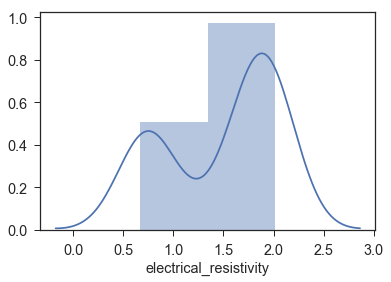

In [252]:
electricdata=modeldatas['electrical_resistivity']
n=electricdata.shape[0]
electricdata=electricdata.dropna(axis=1,thresh=int(0.4*n))
electricdata=electricdata.fillna(electricdata.mean())
electricdata=electricdata[electricdata['electrical_resistivity']>=0]
electricdata=electricdata[electricdata['electrical_resistivity']<3]
n=electricdata.shape[0]
electricdata=electricdata.drop(columns=['Longitudinal_Annealing_field','Transverse_Annealing_field'])
header=list(electricdata.columns.values)
designmatrix=electricdata.as_matrix()
sns.distplot(electricdata['electrical_resistivity'])
print('Count of entry:')
print(n)

#### Plot electrical resistivity with each predictors

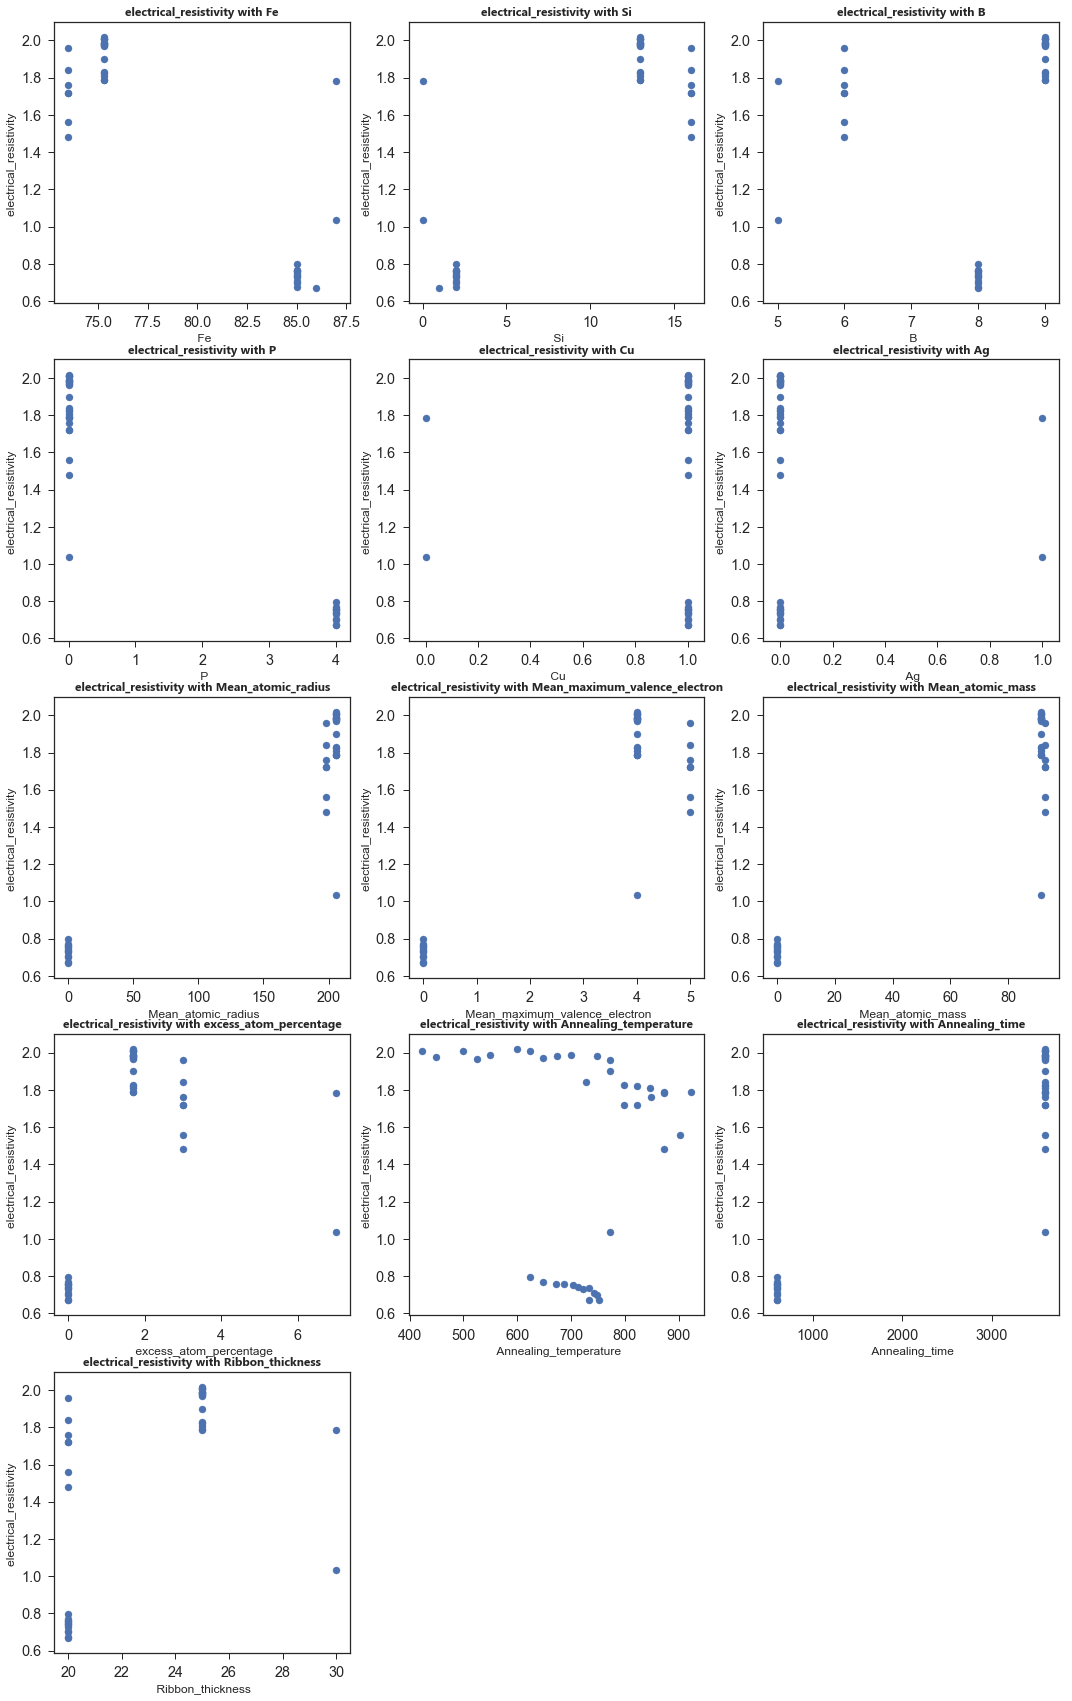

In [253]:
fig = plt.figure(figsize=(18,30))
for i in range(np.size(designmatrix,1)-1):
    ax = fig.add_subplot(5,3,i+1)
    ax.scatter(designmatrix[:,i],designmatrix[:,-1],marker="o", s=50)
    ax.set_xlabel(" %s"%header[i],fontsize=12, fontweight='normal')
    ax.set_ylabel("electrical_resistivity ",fontsize=12, fontweight='normal')
    ax.set_title("electrical_resistivity with %s"%header[i], fontweight='bold', fontsize=12, fontname='Segoe UI')
    #plt.savefig("Figure2_{y}.png".format(y=header[i]),dpi=500)


#### Adding quadratic term of annealing temperature

In [254]:
electricdata.insert(0,"quad_temperature", np.power(electricdata['Annealing_temperature'],2))

#### Model building

In [255]:
electricdata=electricdata.reset_index(drop=True)
#electricdata.insert(0,"quad_temperature", np.power(electricdata['Annealing_temperature'],2))
header=list(electricdata.columns.values)
lmstr=header[-1]+" ~ "+header[0]#+" + "+"np.power("+header[0]+",2)"
for i in range(len(header)-2):
    lmstr=lmstr+'+'+header[i+1]#+" + "+"np.power("+header[i+1]+",2)"
#mod = sm.RLM.from_formula(lmstr,data=electricdata,M=sm.robust.norms.HuberT()).fit()
mod=ols(lmstr,data=electricdata).fit()

#### Influential plot based on cooks distance

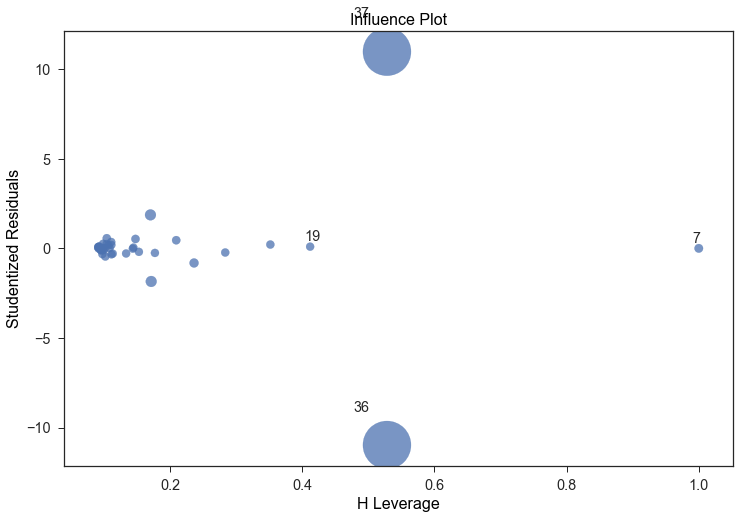

In [248]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(mod, ax=ax, criterion="Cooks") 

#### Drop high leverage data

In [ ]:
electricdata=electricdata.drop(electricdata.index[[37,36]])

#### Partial regression plot

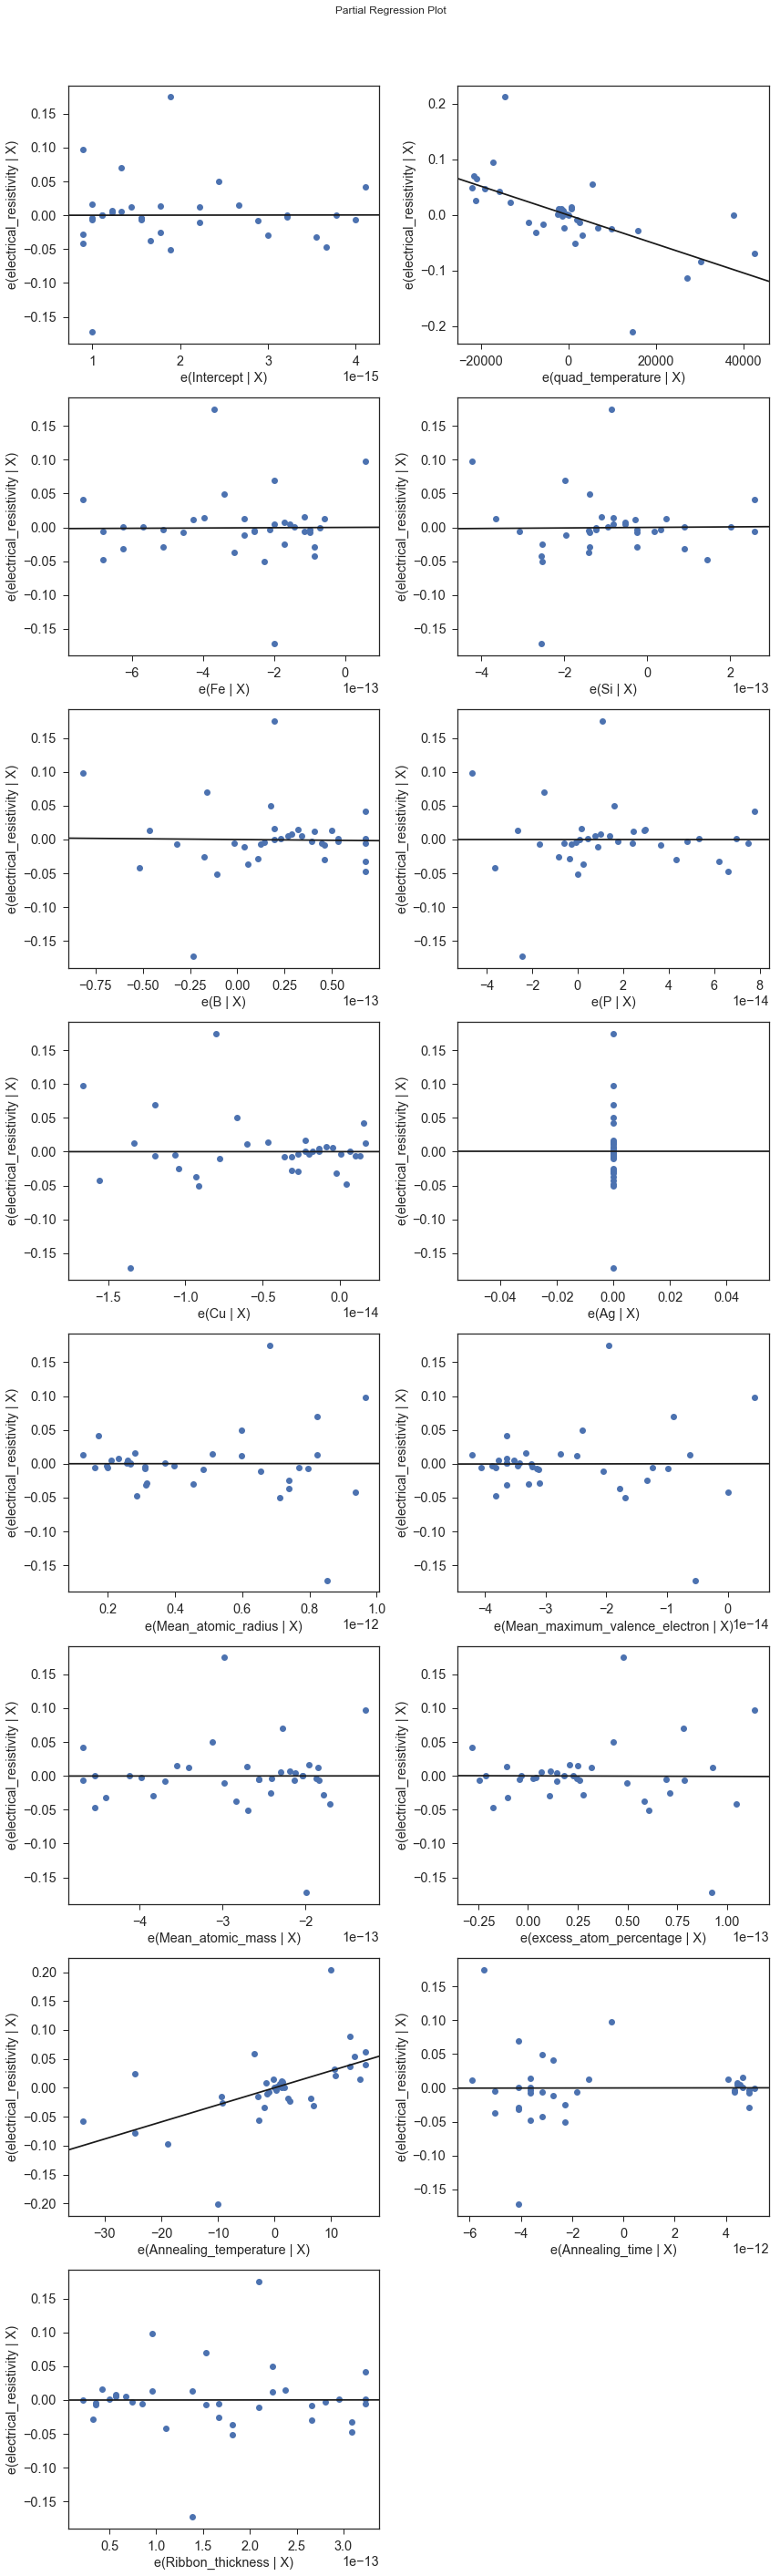

In [256]:
params = {'legend.fontsize': 'x-large',
          'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
fig = plt.figure(figsize=(12,40))
fig = sm.graphics.plot_partregress_grid(mod, fig=fig)


#### Retain effective features

In [260]:
electricdataselect=electricdata.drop(columns=['P','Fe','Si','B','Cu','Ag','Mean_maximum_valence_electron','Mean_atomic_mass','excess_atom_percentage'])
header=list(electricdataselect.columns.values)
lmstr=header[-1]+" ~ "+header[0]#+" + "+"np.power("+header[0]+",2)"
for i in range(len(header)-2):
    lmstr=lmstr+'+'+header[i+1]#+" + "+"np.power("+header[i+1]+",2)"
mod = sm.RLM.from_formula(lmstr,data=electricdataselect,M=sm.robust.norms.HuberT()).fit()


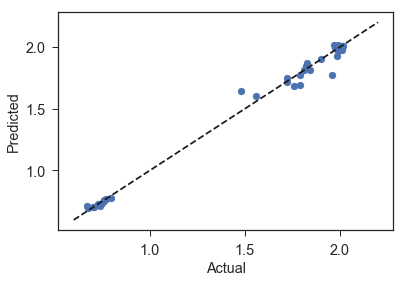

In [261]:
Ynew=electricdataselect['electrical_resistivity']
fig,ax = plt.subplots()
ax.scatter(Ynew,mod.fittedvalues)
ax.plot([0.6,2.2],[0.6,2.2],'k--')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

#### Print out and save electrical resistivity model

In [262]:
print(mod.params)
moddict['electrical_resistivity']=[mod,'none','none']

Intercept                0.000107
quad_temperature        -0.000002
Mean_atomic_radius       0.009247
Annealing_temperature    0.002630
Annealing_time          -0.000245
Ribbon_thickness         0.010581
dtype: float64


## Model results
### We obtain 9 different statistical model for different materials properties includes: 
####  Regression model for
* Coercivity
* Magnetostriction
* Magnetic saturation with early transition metal
* Magnetic saturation without early transition metal
* Core loss
* Low permeability (ln(permeability)=(0,8])
* High permeability (ln(permeability)=(8,14])
* Electrical resistivity 

#### Classification model for
* Differentiate permeability between low and high

## Making prediction
#### Using our model to investigate the influence of annealing temperature of magnetic saturation and magnetostriction on:
* Composition $Fe_{73.5}Si_{13.5}B_9Cu_1Nb_3$, 
* Annealing time 3600s,  
* No field annealing, 
* Ribbon thickness 21 $\mu$m

In [227]:
# print key values of the dictionary containing our models
for key, value in moddict.items() :
    print (key)

Coercivity
magnetostriction
magsat_ex
magsat_nonex
core_loss
permeability_classifier
permeability_low
permeability_high
electrical_resistivity


In [297]:
model_sat=moddict['magsat_ex'][0]
lams_sat=moddict['magsat_ex'][1]
model_str=moddict['magnetostriction'][0]
lams_str=moddict['magnetostriction'][1]

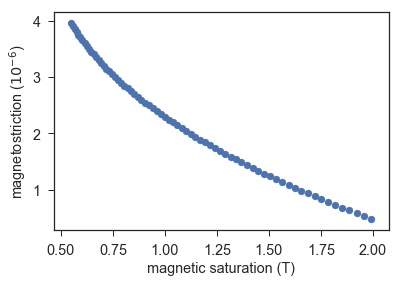

In [304]:
temp=np.array(range(400,1100,10))
datamatrix=[]
for i in temp: 
    datamatrix.append([73.5,13.5,0,9,0,0,0.00001,0,1,0,0,0,198,5,92.906,3,i,3600,0,0,21])
datamatrix=np.array(datamatrix)
header=np.array(['Fe','Si','C','B','Al','Ga','P','Ge','Cu','Ag','Au','Zn','Mean_atomic_radius','Mean_maximum_valence_electron','Mean_atomic_mass','excess_atom_percentage','Annealing_temperature','Annealing_time','Longitudinal_Annealing_field','Transverse_Annealing_field','Ribbon_thickness'])
dataf=pd.DataFrame(datamatrix,columns=header)
data_sat=dataf.copy()
for i in lams_sat:
    if lams_sat[i]==0:
        data_sat[i]=np.log(data_sat[i])
    else:
        data_sat[i]=np.power(data_sat[i],lams_sat[i])
data_str=dataf.copy()    
pred_sat=model_sat.predict(data_sat)
pred_str=model_str.predict(data_str)
fig,ax = plt.subplots()
ax.scatter(pred_sat,pred_str)
ax.set_xlabel('magnetic saturation (T)')
ax.set_ylabel('magnetostriction ($10^{-6}$)')
plt.show()

#### Using our model to investigate the influence of annealing temperature of magnetic saturation and coercivity

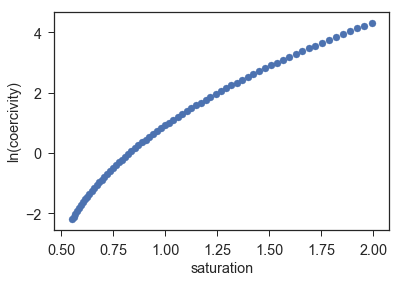

In [299]:
model_sat=moddict['magsat_ex'][0]
lams_sat=moddict['magsat_ex'][1]
model_coe=moddict['Coercivity'][0]
lams_coe=moddict['Coercivity'][1]
data_coe=dataf.copy()
for i in lams_coe:
    if lams_coe[i]==0:
        data_coe[i]=np.log(data_coe[i])
    else:
        data_coe[i]=np.power(data_coe[i],lams_coe[i])
pred_coe=model_coe.predict(data_coe)   
fig,ax = plt.subplots()
ax.scatter(pred_sat,pred_coe)
ax.set_xlabel('magnetic saturation (T)')
ax.set_ylabel('ln(coercivity)')
plt.show()

#### Using our model to investigate the influence of annealing temperature of magnetic saturation and electrical resistivity

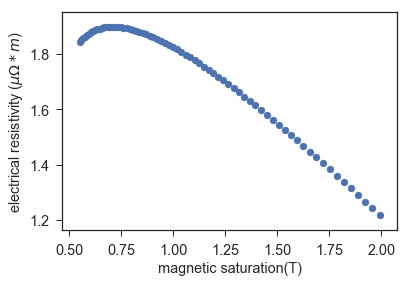

In [314]:
fig,ax = plt.subplots()
ax.scatter(pred_sat,pred_res)
ax.set_xlabel('magnetic saturation(T)')
ax.set_ylabel('electrical resistivity ($\mu \Omega*m$)')
plt.show()